# Optimización de gastos de marketing en Y.afisha

Se presenta el desarrollo de un análisis para mejorar la utilización de dineros por parte de la empresa. Trabajamos directamente desde el departamento de análisis de Y.Afisha para optimizar sus gastos de marketing.

Contamos con registros del servidor con datos del sitio de la empresa para periodos desde el año 2017 a 2018. En base al historial de sesiones y pedidos de los usuarios, identificaremos los comportamientos pertinentes para determinar cómo los usuarios interactúan con el sitio.

A su vez, contamos con registros de los gastos del departamento de marketing para estudiar las distintas fuentes de anuncio de la que proceden sus gastos y así poder determinar cuáles son las más rentables dependiendo del comportamiento de los usuarios que observemos.

**Tabla de contenidos:**

 **1. Inicialización:**
 
    - Verificación y descripción
    - Carga de datos
    - Conclusiones preliminares
    
    
 **3. Preprocesamiento de datos:**
 
    - Corrección de datos
    - Comprobación de datos ausentes
    - Registros duplicados
    - Comprobación de valores
    - Conclusiones del preprocesamiento
 
 
 **4. Análisis de datos:**
 
    - Planteamiento de interrogantes
    - Análisis del producto
    - Análisis de las ventas
    - Análisis de los gastos
    - Beneficio bruto
    - Costo de adquisición
    - Retorno de la inversión
    - Conclusiones 
    
 **6. Conclusiones finales**
 
    - Resumen del análisis
    - Observaciones
    - Recomendaciones

## Inicialización

Cargamos las librerías necesarias:

In [1]:
# Cargamos las librerías
import pandas as pd
import math
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import lines
from matplotlib import patches
from matplotlib.patheffects import withStroke

**Tenemos los datos de visitas, pedidos y gastos en variables.**

**Crearemos un dataset para cada uno de estos tres conjuntos, pero antes de eso, comprobaremos el tamaño de cada archivo para optimizar su carga.**

### Dataset 1: Visitas

#### Verificación y descripción de datos

1. Descargamos una porción de los datos:

In [2]:
# Primer dataset: Visitas a Y.Afisha
visits_df = pd.read_csv('/datasets/visits_log_us.csv', nrows=500)  #limitamos la carga a 500 filas

2. Verificamos el tamaño y división de columnas:

In [3]:
# Buscamos el tamaño exacto de los datos
visits_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Device     500 non-null    object
 1   End Ts     500 non-null    object
 2   Source Id  500 non-null    int64 
 3   Start Ts   500 non-null    object
 4   Uid        500 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 113.1 KB


**Los datos se dividen en 5 columnas:**

**1. Device:**

    - Descripción: dispositivo del usuario en el cual se visualizó la página web.
    - Tipo de datos: Object.

**2. End Ts:**

    - Descripción: Fecha y hora del fin de la sesión.
    - Tipo de datos: Object.
    
**3. Source Id:**

    - Descripción: identificador de la fuente de anuncios de la que proviene el usuario.
    - Tipo de datos: Int64.
    
**4. Start Ts:**

    - Descripción: Fecha y hora del inicio de sesión.
    - Tipo de datos: Object.
    
**5. Uid:**

    - Descripción: Identificador único del usuario.
    - Tipo de datos: uint64.

Además, nuestra muestra tiene un peso de 113,1 KB.; por lo tanto, optimizaremos la carga de datos cambiando algunos datos de tipo Object:

- Verificaremos la cantidad de dispositivos en **Device** para cambiar esta columna a tipo category.
- **Start Ts** y **End Ts** pueden ser cambiados de tipo Object a datetime.

In [4]:
# Valores en la columna Device
visits_df['Device'].value_counts()

desktop    363
touch      137
Name: Device, dtype: int64

Al parecer solo contamos con estos dos valores: desktop y touch. Cambiaremos a tipo category para reducir el tamaño de los datos.

In [5]:
# Cambiamos el tipo de datos de la columna
visits_df['Device'] = visits_df['Device'].astype('category')

# Vemos el nuevo tamaño
visits_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Device     500 non-null    category
 1   End Ts     500 non-null    object  
 2   Source Id  500 non-null    int64   
 3   Start Ts   500 non-null    object  
 4   Uid        500 non-null    uint64  
dtypes: category(1), int64(1), object(2), uint64(1)
memory usage: 82.9 KB


Pudimos reducir desde 113,1 KB a 82,9 KB. Seguimos con las fechas:

In [6]:
#Comprobamos el formato de las fechas
visits_df.head(2)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740


In [7]:
# Procedemos a ejecutar el cambio de tipo de datos
visits_df['Start Ts'] =  pd.to_datetime(visits_df['Start Ts'], format="%Y-%m-%d %H:%M:%S")
visits_df['End Ts'] =  pd.to_datetime(visits_df['End Ts'], format="%Y-%m-%d %H:%M:%S") 

# Vemos como queda el nuevo tamaño
visits_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Device     500 non-null    category      
 1   End Ts     500 non-null    datetime64[ns]
 2   Source Id  500 non-null    int64         
 3   Start Ts   500 non-null    datetime64[ns]
 4   Uid        500 non-null    uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 16.5 KB


Pudimos reducir los datos desde 113,1 KB a 16,5 KB. Es bastante considerable ya que es casi 7 veces el valor inicial. Por lo tanto, cargaremos los datos pero con los tipos de datos correctos desde un inicio.

#### Carga de datos

In [8]:
# Cargamos nuestro primer dataset
visits = pd.read_csv('/datasets/visits_log_us.csv',
                     dtype={'Device': 'category'},
                     parse_dates=['Start Ts', 'End Ts']
                    )

In [9]:
# Vemos la información
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


**Nuestro primer dataset tiene 359400 registros y 5 columnas.** 

El peso de sus datos es de 11.3 MB

### Dataset 2: Orders

#### Verificación y descripción de datos

1. Descargamos una porción de los datos:

In [10]:
# Segundo dataset: órdenes en Y.Afisha
orders_df = pd.read_csv('/datasets/orders_log_us.csv', nrows=500)  #limitamos la carga a 500 filas

2. Verificamos el tamaño y división de columnas:

In [11]:
# Buscamos el tamaño exacto de los datos
orders_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   500 non-null    object 
 1   Revenue  500 non-null    float64
 2   Uid      500 non-null    uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 45.0 KB


**Los datos se dividen en 3 columnas:**

**1. Buy Ts:**

    - Descripción: Fecha y hora del pedido.
    - Tipo de datos: Object.

**2. Revenue:**

    - Descripción: Ingresos de Y.afisha de este pedido.
    - Tipo de datos: float64.
    
**3. Uid:**

    - Descripción: Identificador único del usuario que realiza el pedido.
    - Tipo de datos: uint64.
    

Tenemos un peso de 45 KB. para esta muestra. Optimizaremos la carga de datos cambiando el tipo de datos de la columna **Buy Ts** a datetime.

In [12]:
#Comprobamos el formato de las fechas
orders_df.head(2)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


In [13]:
# Procedemos a ejecutar el cambio de tipo de datos
orders_df['Buy Ts'] =  pd.to_datetime(orders_df['Buy Ts'], format="%Y-%m-%d %H:%M:%S")

# Vemos como queda el nuevo tamaño
orders_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   500 non-null    datetime64[ns]
 1   Revenue  500 non-null    float64       
 2   Uid      500 non-null    uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 11.8 KB


Pudimos reducir los datos desde 45 KB a 11,8 KB. Casi 4 veces lo contemplado en un comienzo. 

Cargaremos los datos completos asignando desde un comienzo el tipo de datos de fecha y hora.

#### Carga de datos

In [14]:
# Cargamos nuestro primer dataset
orders = pd.read_csv('/datasets/orders_log_us.csv',
                     parse_dates=['Buy Ts']
                    )

In [15]:
# Vemos la información
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


**Nuestro segundo dataset tiene 50415 registros y 3 columnas.** 

El peso de sus datos es de 1.2 MB

### Dataset 3: gastos de marketing

#### Verificación y descripción de datos

1. Descargamos una porción de los datos:

In [16]:
# Tercer dataset: gastos de marketing
costs_df = pd.read_csv('/datasets/costs_us.csv', nrows=500)  #limitamos la carga a 500 filas

2. Verificamos el tamaño y división de columnas:

In [17]:
# Buscamos el tamaño exacto de los datos
costs_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  500 non-null    int64  
 1   dt         500 non-null    object 
 2   costs      500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 40.7 KB


**Los datos se dividen en 3 columnas:**

**1. source_id:**

    - Descripción: identificador de la fuente de anuncios.
    - Tipo de datos: int64.

**2. dt:**

    - Descripción: Fecha.
    - Tipo de datos: Object.
    
**3. costs:**

    - Descripción: gasto en esta fuente de anuncio en este día.
    - Tipo de datos: float64.

La muestra tiene un peso de 40,7 KB. 

Vemos que es posible optimizar esta cifra a través de la columna de fecha **dt**.

In [18]:
#Comprobamos el formato de las fechas
costs_df.head(2)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25


In [19]:
# Procedemos a ejecutar el cambio de tipo de datos
costs_df['dt'] =  pd.to_datetime(costs_df['dt'], format="%Y-%m-%d") 

# Vemos como queda el nuevo tamaño
costs_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  500 non-null    int64         
 1   dt         500 non-null    datetime64[ns]
 2   costs      500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.8 KB


Pudimos reducir los datos desde 40,7 KB a 11,8 KB. 

Cargaremos todos los datos pero aplicando de forma inmediata este cambio de tipo de datos.

#### Carga de datos

In [20]:
# Cargamos nuestro primer dataset
costs = pd.read_csv('/datasets/costs_us.csv',
                     parse_dates= ['dt']
                    )

In [21]:
# Vemos la información
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


**Nuestro tercer dataset tiene 2542 registros y 3 columnas.** 

El peso de sus datos es de 59,7 KB.

**Ya cargamos nuestros tres dataset: visits, orders y costs.**

### Conclusiones preliminares de acuerdo a la información de los datos

A partir de 3 archivos CSV hemos creado 3 dataset con información relevante de Y.Afisha para optimizar sus gastos de marketing.
Estos 3 dataset los ordenamos de la siguiente forma:

**El primer dataset: visits**, nos muestra los registros del servidor con datos de las visitas a Y.Afisha desde enero de 2017 a diciembre de 2018. Su información se presenta ordenada en cinco columnas:

    - Device
    - End Ts
    - Source Id
    - Start Ts
    - Uid


**El segundo dataset: orders**, nos entrega información de todos los pedidos del periodo antes señalado. La información se presenta en tres columnas:

    - Uid
    - Buy Ts
    - Revenue

**El tercer dataset: costs**, nos da las estadísticas de gastos de marketing. La información se presenta en tres columnas:

    - source_id
    - dt
    - costs


**Respecto a la cantidad de datos:**

- Visits: 359400 registros.
- Orders: 50415 registros.
- Costs: 2542 registros.

**Respecto al tamaño de los datos:**

En todos los dataset aplicamos una optimización de los datos cargando desde un inicio los tipos de datos adecuados dependiendo de las columnas.

En **visits** el tamaño final es de **11.3 MB**. Se aplicó el tipo de datos *category* a la columna **Device** y el tipo de datos *datetime* a **Start Ts** y **End Ts**. Estas medidas lograron reducir los datos en siete veces su tamaño.

En **orders** el tamaño final es de **1.2 MB**. Se redujo en cuatro veces el tamaño aplicando el tipo de datos *datetime* a la columna **Buy Ts**.

En **costs** el tamaño final es de **59.7 KB**. También para este dataset se redujo en casi 4 veces el tamaño aplicando el tipo *datetime* a la columna **dt**.


**Respecto al tipo de datos:**

- Los cambios aplicados en durante la optimización fueron los únicos necesarios para establecer el tipo correcto. Recordamos que las fechas fueron cambiadas a *datetime* (columnas Start Ts, End Ts y Buy Ts), mientras que Device fue cambiado a tipo *category*.


**Otros aspectos:**

- Es necesario verificar que los categorías en **Device** sigan siendo dos tal cual lo observamos en la muestra.

- Se tendrá que revisar si existen registros duplicados y datos ausentes en cada uno de los dataset.

- Comprobaremos los valores en la columna **Revenue** del segundo dataset y **costs** en el tercer dataset para asegurarnos que sean realistas.

- Se hace necesario aplicar *snake case* a las columnas para facilitar el trabajo posterior.

- La columna Uid de **Visits** conecta con Uid de **Orders**.

## Preprocesamiento de datos

Resolveremos los pocos problemas que observamos en nuestros tres dataset. El preprocesamiento se realizará en el siguiente orden:

    1. Aplicamos snake case a los tres dataset para cambiar el nombre de las columnas.
    2. Comprobación de datos ausentes.
    3. Registros duplicados.
    4. Verificación de duplicados implícitos y otros valores en la columna Device.
    5. Comprobación de valores en columnas Revenue y costs.
    6. Orden de las columnas para correcta visualización en los dataframes.

### Corrección de nombres de columnas

In [22]:
# Vemos los nombres de columnas para el primer dataset
visits.columns

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

In [23]:
#Cambiamos los nombres a minúsculas y unimos los espacios con guión bajo
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [24]:
# Vemos los nombres de columnas para el segundo dataset
orders.columns

Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

In [25]:
#Cambiamos los nombres a minúsculas y unimos los espacios con guión bajo
orders.columns = ['buy_ts', 'revenue', 'uid']

In [26]:
# Vemos los nombres de columnas para el tercer dataset
costs.columns

Index(['source_id', 'dt', 'costs'], dtype='object')

En el dataset **costs** los nombres de las columnas ya se presentan como las deseamos por lo tanto no realizamos cambios.

### Comprobación de datos ausentes

In [27]:
# Datos ausentes en primer dataset
visits.isnull().sum()

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

In [28]:
# Datos ausentes en segundo dataset
orders.isnull().sum()

buy_ts     0
revenue    0
uid        0
dtype: int64

In [29]:
# Datos ausentes en tercer dataset
costs.isnull().sum()

source_id    0
dt           0
costs        0
dtype: int64

**No presentamos datos ausentes en alguno de los conjuntos.**

### Comprobación de duplicados

In [30]:
# Verificación en primer dataset
visits.duplicated().sum()

0

In [31]:
# Verificación en segundo dataset
orders.duplicated().sum()

0

In [32]:
# Verificación en tercer dataset
costs.duplicated().sum()

0

**No presentamos registros duplicados en alguno de los dataset.**

### Verificación de duplicados implícitos y otros valores en columna Device.

In [33]:
# vemos los valores de la columna Device en el primer dataset
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

**Contamos solo con dos valores: desktop y touch.** Todo está en orden y no necesitamos hacer cambios. 

### Comprobación de valores en las columnas revenue y costs

In [34]:
# Comprobación mediante el método describe
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Recordamos que revenue corresponde a los ingresos de Y.Afisha por cada pedido.
Del un total de 50415 pedidos tenemos que:

    - La media de ingresos es de 5 aproximadamente.
    - El mínimo es 0, lo cual es extraño pero no descartable, tendremos que entender con mayor profundidad los pedidos de valor 0 más adelante.
    - La mediana es de 2.5.
    - El pedido de valor máximo es de 2633.28, lo cual es bastante anormal con respecto a los otros datos pero no lo podemos descartar aún.
    
Ahora analizamos la columna costs del tercer dataset.

In [35]:
# Comprobación mediante el método describe
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Costs está asociado al gasto de marketing en la fuente de anuncio en X día.

De un total de 2542 registros de gastos, tenemos que:

    - La media de gasto de marketing es de 129.47 por día.
    - La mínima en un día fue de 0.54
    - La mediana es de 77.29.
    - El gasto máximo en una fuente de anuncio fue de 1788.28 por el día.

Tanto revenue como costs presentan valores razonables para su naturaleza, sin embargo se hace necesario observar en más detalle el valor mínimo de revenue y los valores máximos tanto para revenue como costs.

### Orden de columnas

Veamos si los tres dataframe se presentan de una forma clara y legible antes de pasar al análisis de datos.

In [36]:
# Vemos el primer dataset
visits.head(5)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Pasaremos la columna **start_ts** delante de **end_ts** para que sigan un orden lógico.

In [37]:
# Reordenamos las columnas
visits = visits.reindex(columns=['device', 'start_ts', 'end_ts', 'source_id', 'uid'])

In [38]:
# Vemos nuevamente la tabla
visits.head(5)

,device,start_ts,end_ts,source_id,uid
0,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,16879256277535980062
1,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,104060357244891740
2,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5,7459035603376831527
3,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,16174680259334210214
4,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3,9969694820036681168


Ahora si se ve más ordenada.

In [39]:
#Vemos el segundo dataset
orders.head(5)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


No consideramos necesarios cambios.

In [40]:
# Vemos el tercer dataset
costs.head(5)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


No es necesario hacer cambios.

Ya tenemos los tres dataset listos para empezar el análisis. A continuación, se describe el resumen de las modificaciones hechas en el preprocesamiento de los datos:

### Conclusiones del preprocesamiento de datos

Los conjuntos no contienen valores ausentes ni registros duplicados. Se realizaron algunos ajustes menores a los tres dataset: visits, orders y costs. 

- Aplicación de snake_case para cambiar el nombre de las columnas.
- Se verificaron los valores de la columna Device y confirmamos que solo tenemos dos valores: desktop y touch.
- Se hace necesario complementar la información de valores mínimos y máximos para revenue y costs para entender el contexto de estos montos.
- Se cambio de orden las columnas en el dataset visits para que se entendiera de mejor manera.


## Análisis de datos

Previo al análisis, plantearemos algunas interrogantes que serán resueltas en el desarrollo de este mismo. Estas preguntas estarán dirigidas a la información que poseemos en cada dataset y nos ayudarán  a dirigir nuestro aprendizaje y estudio de los datos. Por otro lado, también nos ayudarán a enriquecer nuestros datos con valores útiles que ayudaran en desarrollar un análisis más completo para la compañía.


### Planteamiento de interrogantes

#### Dataset 1: Visitas a plataforma de Y.Afisha

Un punto importante a considerar es que los registros contemplan fechas desde **enero del 2017 a diciembre del 2018; es decir, dos años completos.** No sabemos a ciencia cierta si efectivamente los datos tendrán esos límites de fechas pero al menos consideramos ese rango.

Recordamos también que en este dataset tenemos las siguientes columnas: *device, start_ts, end_ts, source_id, uid.* 

Y teniendo en cuenta que **el objetivo es entender el comportamiento de los clientes para optimizar el gasto de marketing**, nos hacemos las siguientes preguntas respecto a este dataset:

- ¿Cuántas personas ingresan a Y.Afisha diariamente?¿cuántas lo hacen semanal o mensualmente?
- ¿Cuántas sesiones se abren por día aproximadamente?
- ¿Cuál es la duración de cada sesión?
- ¿Con qué frecuencia vuelven los usuarios?
- ¿Existe algún patrón de conducta interesante respecto al dispositivo que utilizan?
- ¿De qué fuentes de anuncio provienen la mayoría de usuarios?

#### Dataset 2: Pedidos

Todos los pedidos entre enero del 2017 a diciembre del 2018 se encuentran alojados acá; por lo tanto, **será importante unir las tablas mediante el identificador de usuario único *uid* para establecer algunas conclusiones.**

Tenemos las siguientes columnas: *buy_ts, revenue, uid*. Junto a los datos antes trabajados podemos establecer las siguientes preguntas:

- ¿Cuándo comienzan a comprar las personas? (Importante observar el tiempo entre start_ts y buy_ts)
- ¿Qué canal de marketing registra mayores ventas?
- ¿Cuántos pedidos se hacen en los periodos más rentables? ¿Cuántos se hacen en los menos?
- ¿Cuál es el monto promedio de las compras?
- ¿Cuánto dinero traen los clientes?

#### Dataset 3: costos de marketing

El gasto en marketing queda reflejado en este dataset, el que se puede unir al primero por medio de la columna **source_id**. Las otras columnas: *dt y costs* nos indican la fecha y costo para tales fuentes de anuncios. En base a esto, algunas preguntas que nos podemos hacer son:

- ¿Cuánto dinero total se ha gastado?
- ¿Cuánto dinero se ha gastado por cada fuente de anuncios?
- ¿Cuáles han sido los periodos de mayor gasto de marketing?
- ¿Cuánto costó la adquisición de clientes de cada una de las fuentes?
- ¿Cuán rentable eran las inversiones?

Las preguntas planteadas para los dataset nos servirán de base para explorar en la información recopilada. Ahora, procedemos a responderlas.

<div class="alert alert-block alert-success">
<b>Muy bien</b> <a class="tocSkip"></a>

Que buena estructura le ha dado usted a su proyecto. De verdad es poco común que los estudiantes sigan una narrativa tan detallada como la que usted implementa. Una narrativa sólida es fundamental para construir un protafolio sólido. 


</div>

### Análisis de datos: Información del producto

Por medio de las preguntas, nos dimos cuenta que podemos mejorar nuestras tabla agregando algunas columnas. Los datos que podemos agregar al primer dataset a partir de las fechas son:

    - Fecha de el primer inicio de sesión del usuario.
    - Semana de la sesión.
    - Mes de la sesión.
    
Veamos como es nuestra primera tabla:

In [41]:
# Dataset de visitas
visits.head(5)

,device,start_ts,end_ts,source_id,uid
0,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,16879256277535980062
1,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,104060357244891740
2,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5,7459035603376831527
3,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,16174680259334210214
4,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3,9969694820036681168


A partir de nuestra columna *start_ts* podemos calcular el número de visitantes para los periodos que estimemos, además de calcular el número de sesiones iniciadas por día.

Si consideramos también la columna *end_ts*, podemos calcular la duración promedio de cada sesión.

comencemos aclarando estas dudas para ver el panorama global de nuestra plataforma:


#### Número de visitantes

In [42]:
# Agregamos columnas para año, mes, semana y día
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.isocalendar().week
visits['session_date'] = visits['start_ts'].dt.date

#Veamos como queda la tabla
visits.head(5)

,device,start_ts,end_ts,source_id,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3,9969694820036681168,2017,12,52,2017-12-27


La agregación de estas nuevas columnas nos permitirá explorar la actividad de los usuarios. Podemos determinar tres métricas:

- El número de usuarios únicos activos diarios (DAU).
- El número de usuarios únicos activos semanales (WAU).
- El número de usuarios únicos activos mensuales (MAU).
- El número de usuarios únicos activos anuales (YAU)

Agruparemos los datos de acuerdo a las fechas y buscaremos las medias:

In [43]:
#DAU
dau_total = visits.groupby(['session_date']).agg({'uid': 'nunique'}).mean()
int(dau_total)

907

In [44]:
#WAU
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
int(wau_total)

5716

In [45]:
#MAU
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
int(mau_total)

23228

In [46]:
#YAU
yau_total = visits.groupby(['session_year']).agg({'uid': 'nunique'}).mean()
int(yau_total)

122156

Estas métricas solo nos dan información básica de la actividad que tenemos en Y.Afisha. No nos entregan un entendimiento más profundo pero si pueden jugar un rol importante a la hora de motivar al equipo. 

Como resultado tenemos que:
 - **La media de visitas diarias es de 907 usuarios.**
 - **La media de visitas semanales es de 5716 usuarios.**
 - **La media de visitas mensuales es de 23228 usuarios.**
 - **La media de visitas anuales es de 122156 usuarios.**

Veamos ahora una métrica para ver qué tan leal es la audiencia. El sticky factor (o factor de adherencia) nos revelará con qué frecuencia los usuarios regresan a Y.Afisha.

#### Frecuencia de regreso de los usuarios

In [47]:
#Factor de adherencia semanal
sticky_wau = (dau_total / wau_total) * 100
sticky_wau

uid    15.884409
dtype: float64

In [48]:
#Factor de adherencia mensual
sticky_mau = (dau_total / mau_total) * 100
sticky_mau

uid    3.90897
dtype: float64

In [49]:
#Factor de adherencia anual
sticky_yau = (dau_total / yau_total) * 100
sticky_yau

uid    0.743305
dtype: float64

    El factor de adherencia semanal es de un 15.88%.
    El factor de adherencia mensual es de un 3.90%.
    El factor de adherencia anual es de un 0.74%.

   La frecuencia con la que vuelven los usuarios es relativamente baja. No tenemos mayores detalles del tipo de bien o servicio que ofrece Y.Afisha, pero en cualquier caso, la adherencia de clientes tanto a corto como largo plazo es baja. Estamos hablando de que aproximadamente solo una sexta parte de los usuarios que ingresan por primera vez, lo vuelven a hacer durante la misma semana. 
  

#### Sesiones de usuario: cantidad

Vamos a explorar las sesiones de usuario para ver cuánto tiempo pasan en nuestra plataforma. Para esto, estimaremos el tiempo entre *start_ts y end_ts* lo que va a ser útil además para determinar la frecuencia de uso de la aplicación.

In [50]:
# Sesiones por usuario agrupadas por mes y año
sessions_per_user = visits.groupby(['session_year', 'session_month']).agg({'uid': ['count', 'nunique']})
# Cambiamos de nombre las columnas
sessions_per_user.columns = ['n_sessions', 'n_users']
# Creamos una nueva columna para calcular la cantidad de sesiones por usuario
sessions_per_user['sess_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])

sessions_per_user

n_sessions  n_users  sess_per_user
session_year session_month                                    
2017         6                   16505    13259       1.244815
             7                   17828    14183       1.256998
             8                   14355    11631       1.234202
             9                   23907    18975       1.259921
             10                  37903    29692       1.276539
             11                  43969    32797       1.340641
             12                  41983    31557       1.330386
2018         1                   36939    28716       1.286356
             2                   37182    28749       1.293332
             3                   35679    27473       1.298693
             4                   26515    21008       1.262138
             5                   26635    20701       1.286653

En promedio, **cada usuario pasa al menos 1 sesión al mes**. No es una plataforma que se use con mucha frecuencia.

Veamos ahora cuántas sesiones se abren al día:

In [51]:
# Número de sesiones diarias
visits.groupby(['session_date']).agg({'uid': ['count', 'nunique']}).mean()

uid  count      987.362637
     nunique    907.991758
dtype: float64

**El número de sesiones diarias abiertas en la plataforma es en promedio 987.**

**El número de sesiones por usuario único abiertas en el día es de 908 en promedio.**

#### Sesiones de usuario: duración 

Vamos a calcular la duración media de las sesiones para determinar el tiempo que usan los usuarios la plataforma en cada sesión:

In [52]:
# ASL (Average session lenght)
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
# Calculamos la media de todas las sesiones
visits['session_duration_sec'].mean()

643.506488592098

**Cada sesión dura en promedio 643 segundos**. Veamos en minutos cuánto es:

In [53]:
visits['session_duration_sec'].mean() / 60

10.725108143201632

**Casi 11 minutos dura cada sesión.** 

Veamos la distribución gráficamente para ver si tomar la media fue una buena elección:

<AxesSubplot:>

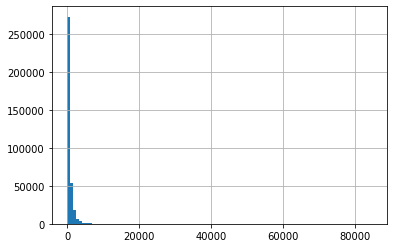

In [54]:
# Histograma
visits['session_duration_sec'].hist(bins=100)

Las duraciones de las sesiones no se distribuyen de una forma uniforme; al menos tenemos un grupo de más de 50 mil sesiones con un tiempo medio distinto, por lo tanto, calcularemos la moda.

In [55]:
# Moda de la duración de las sesiones
asl = visits['session_duration_sec'].mode()
asl

0    60
dtype: int64

Esto es más coherente con la realidad gráfica. **En promedio las sesiones duran solo 1 minuto.** Es necesario verificar por qué están siendo tan cortas.

#### Análisis de cohortes por fechas

Ya que tenemos la duración media de las sesiones de los usuarios, vamos a analizar el comportamiento de acuerdo a las fechas para determinar si existe algún patrón. 

Vamos a usar cohortes para usuarios que usaron la plataforma en diferentes periodos de tiempo. Además, observaremos el primer ingreso de los usuarios y su continuidad a través del tiempo.

In [56]:
# Primera sesión de cada cliente
first_session_by_users = visits.groupby('uid')['start_ts'].min()
first_session_by_users.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: start_ts, dtype: datetime64[ns]

Vamos a unir estos datos a nuestra tabla de visits:

In [57]:
# Cambiamos el nombre de la columna
first_session_by_users.name = 'first_session_date'

# Unimos a la tabla de visits
visits = visits.join(first_session_by_users, on='uid')

#Agregamos una columna para el mes de la primera sesión y así formar cohortes
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')

# Agrupamos los cohortes por meses y calculamos cantidad de usuarios que ingresan por primera vez y tiempo total de los usuarios
cohort_grouped = visits.groupby('first_session_month').agg({'uid': 'nunique', 'session_duration_sec': 'sum'})

# Pasamos los valores del índice  a una nueva columna
cohort_grouped = cohort_grouped.reset_index()

cohort_grouped

,first_session_month,uid,session_duration_sec
0,2017-06-01,13259,34292438
1,2017-07-01,13140,15782855
2,2017-08-01,10181,11258443
3,2017-09-01,16704,17178512
4,2017-10-01,25977,26044026
5,2017-11-01,27248,31765319
6,2017-12-01,25268,23609275
7,2018-01-01,22624,18727949
8,2018-02-01,22197,17160162
9,2018-03-01,20589,15337597


Veamos gráficamente el comportamiento de ingreso de nuevos usuarios y la cantidad de tiempo total que pasaron en las sesiones.

Text(0, 0.5, 'Cantidad de usuarios nuevos')

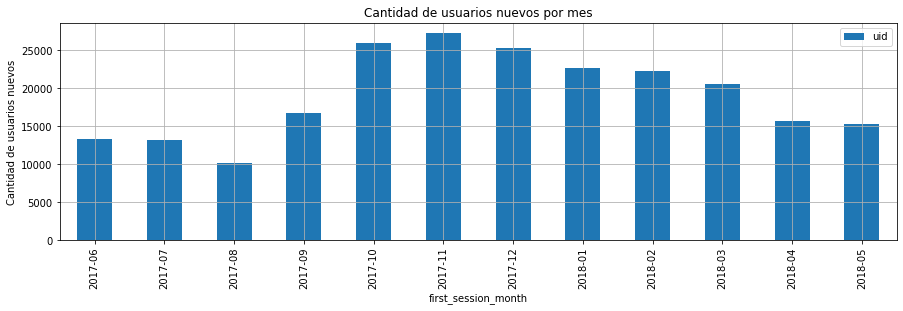

In [58]:
# Dejamos solo el mes y año aplicando el método dt.strftime()
cohort_grouped['first_session_month'] = cohort_grouped['first_session_month'].dt.strftime('%Y-%m')

# Creamos un gráfico de barras para la cantidad de usuarios
cohort_grouped.plot(y='uid', x='first_session_month', kind='bar', 
                    title='Cantidad de usuarios nuevos por mes', grid='True', figsize=(15,4))

plt.ylabel('Cantidad de usuarios nuevos')

El ingreso de nuevos usuarios por cada mes muestra algunas diferencias:

- Los **mejores meses por cantidad de usuarios nuevos** corresponde al periodo desde **Octubre del 2017 a Diciembre del 2017.**
- El **peak se alcanza en noviembre del 2017** superando los 25 mil usuarios nuevos.
- Los meses menos populares para nuestra plataforma fueron desde Junio del 2017 a Agosto del 2017, llegando a alcanzar solo 10 mil usuarios nuevos este último mes.
- Ocurre un crecimiento importante en los meses de septiembre y octubre del 2017; por otro lado, el declive de forma gradual comienza desde noviembre.

El gráfico presenta un comportamiento que quizás se puede catalogar como estacional. Habría que entrar en los detalles de la naturaleza de la plataforma, pero a simple vista se puede concluir que **la plataforma comienza a despertar un interés importante desde el mes de septiembre del 2017, el cual se mantiene y eleva durante el fin de año.** 

Veamos los tiempos totales de sesión para ver si son coherentes con estos aumentos en cantidad de usuarios nuevos:

Text(0, 0.5, 'Tiempo total de las sesiones en segundos')

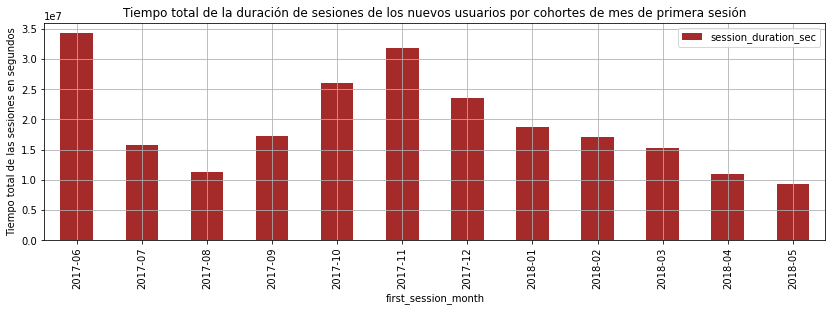

In [59]:
# Creamos un gráfico de barras para el tiempo total de las sesiones
cohort_grouped.plot(y='session_duration_sec', x='first_session_month', kind='bar', 
                    title='Tiempo total de la duración de sesiones de los nuevos usuarios por cohortes de mes de primera sesión',
                    grid='True', color='brown', figsize=(14,4))

plt.ylabel('Tiempo total de las sesiones en segundos')

- Si bien el comportamiento de tiempo es similar a la proporción de cantidad de usuarios nuevos, ocurre que los usuarios que ingresaron por primera vez en Junio del 2017, pasan mucho más tiempo en la plataforma. Vamos a buscar si esto es un patrón general para todos los usuarios de ese mes o existe algún valor atípico considerable que incrementa mucho el valor total.

In [60]:
visits[visits['first_session_month'] == '2017-06-01']['session_duration_sec'].describe()

count    40863.000000
mean       839.205100
std       1328.139381
min          0.000000
25%        120.000000
50%        420.000000
75%       1080.000000
max      30840.000000
Name: session_duration_sec, dtype: float64

Tal como sospechábamos, de un total de 41 mil sesiones aproximadamente para este cohorte, al menos el 75% de los registros están agrupados en una duración bajo los 1080 segundos. Al menos un cuarto de estos registros sobrepasan la media de este grupo que es de 839 segundos por sesión.

*Nota: es natural que el tiempo acumulado pueda ser mayor para el cohorte de usuarios de junio del 2017, ya que corresponde al primer cohorte e involucra más tiempo registrando sesiones. Necesitamos observar las medias para cada cohorte para establecer conclusiones más precisas.*

Veamos la actividad de los usuarios a través del tiempo:

#### Ciclo de vida de los cohortes

Disponemos de cohortes de usuarios de acuerdo al mes en que iniciarion su primera sesión en la plataforma. Analizaremos la actividad de estos con el pasar de los meses para determinar puntos críticos o destacables en cuanto al aumento o disminución de usuarios.

In [61]:
# Creamos una tabla dinámica para la cantidad de usuarios activos de acuerdo a su primer mes de ingreso
visits.pivot_table(index='first_session_month', columns=['session_year', 'session_month'], values='uid', aggfunc='nunique')

session_year            2017                                               \
session_month             6        7        8        9        10       11   
first_session_month                                                         
2017-06-01           13259.0   1043.0    713.0    814.0    909.0    947.0   
2017-07-01               NaN  13140.0    737.0    674.0    738.0    765.0   
2017-08-01               NaN      NaN  10181.0    783.0    640.0    639.0   
2017-09-01               NaN      NaN      NaN  16704.0   1428.0   1156.0   
2017-10-01               NaN      NaN      NaN      NaN  25977.0   2042.0   
2017-11-01               NaN      NaN      NaN      NaN      NaN  27248.0   
2017-12-01               NaN      NaN      NaN      NaN      NaN      NaN   
2018-01-01               NaN      NaN      NaN      NaN      NaN      NaN   
2018-02-01               NaN      NaN      NaN      NaN      NaN      NaN   
2018-03-01               NaN      NaN      NaN      NaN      NaN      NaN   
2018-04-01               NaN      NaN      NaN      NaN      NaN      NaN   
2018-05-01               NaN      NaN      NaN      NaN      NaN      NaN   

session_year                     2018                                      
session_month             12       1        2        3        4        5   
first_session_month                                                        
2017-06-01             809.0    766.0    694.0    674.0    539.0    596.0  
2017-07-01             633.0    596.0    601.0    510.0    376.0    361.0  
2017-08-01             510.0    448.0    370.0    402.0    284.0    265.0  
2017-09-01             847.0    658.0    632.0    599.0    404.0    381.0  
2017-10-01            1357.0   1012.0    890.0    837.0    555.0    529.0  
2017-11-01            2133.0   1202.0   1054.0    919.0    638.0    594.0  
2017-12-01           25268.0   1410.0    960.0    786.0    512.0    481.0  
2018-01-01               NaN  22624.0   1351.0    890.0    565.0    458.0  
2018-02-01               NaN      NaN  22197.0   1267.0    565.0    446.0  
2018-03-01               NaN      NaN      NaN  20589.0    861.0    557.0  
2018-04-01               NaN      NaN      NaN      NaN  15709.0    760.0  
2018-05-01               NaN      NaN      NaN      NaN      NaN  15273.0

- A simple vista se puede ver una drástica caída de usuarios luego de la primera vez que usan la plataforma.
- Si bien para los usuarios de algunos meses existen ciertas remontadas de actividad, la tendencia es clara y muestra que hay una disminución considerable al final del ciclo.

A continuación:
- Vamos a evaluar el ciclo de vida de cada cohorte de usuarios.
- Observaremos los cambios en duraciones de sesión para cada cohorte (análisis pendiente por el comportamiento de Junio del 2017).
- Graficaremos en mapas de calor los resultados para exponerlos claramente.

In [62]:
#Agregamos una nueva columna a visits que tendrá la fecha de la sesión en otro formato
visits['session_date_month'] = visits['session_date'].astype('datetime64[M]')

# Agrupammos los usuarios por cohortes como lo hicimos antes en la tabla dinámica
users_grouped_by_cohorts = visits.groupby(
    ['first_session_month', 'session_date_month']).agg({'session_duration_sec': 'sum', 'uid':'nunique'})

# Agregamos una columna de duración de sesión por usuario
users_grouped_by_cohorts['session_duration_per_user'] = (
    users_grouped_by_cohorts['session_duration_sec'] / users_grouped_by_cohorts['uid']
)

# Reseteamos el índice
users_grouped_by_cohorts = users_grouped_by_cohorts.reset_index()

# Agregamos el tiempo de vida restando las fechas de sesiones
users_grouped_by_cohorts['cohort_lifetime'] = (
    users_grouped_by_cohorts['session_date_month'] - users_grouped_by_cohorts['first_session_month']
)

# Calculamos el tiempo de vida en meses
users_grouped_by_cohorts['cohort_lifetime'] = users_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1, 'M')

# Redondeamos a enteros
users_grouped_by_cohorts['cohort_lifetime'] = (users_grouped_by_cohorts['cohort_lifetime'].round().astype('int'))

# Formateamos a string en formato date dejando solo el mes y año
users_grouped_by_cohorts['first_session_month'] = users_grouped_by_cohorts['first_session_month'].dt.strftime('%Y-%m') 

# Creamos una tabla dinámica para el tiempo de las sesiones por usuario
sessions_per_user_pivot = users_grouped_by_cohorts.pivot_table(
    index='first_session_month',columns='cohort_lifetime', values='session_duration_per_user'
)

sessions_per_user_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06,746.918923,2211.946309,2417.335203,2766.339066,2831.155116,3322.555438,3538.442522,2925.039164,3109.020173,2885.519288,2892.244898,2721.543624
2017-07,644.778919,1345.400271,1285.192878,1213.495935,1497.411765,1176.303318,1036.510067,1168.053245,1155.058824,1067.712766,988.088643,NaN
2017-08,563.925253,1008.505747,1104.843750,1198.122066,1253.764706,1200.669643,1247.837838,1573.134328,1877.957746,1698.113208,NaN,NaN
2017-09,620.770594,1127.058824,1301.107266,1257.378985,982.887538,1114.556962,1052.754591,805.544554,848.976378,NaN,NaN,NaN
2017-10,673.874812,1347.032321,1314.826824,1144.209486,1027.078652,1081.146953,855.891892,1043.364839,NaN,NaN,NaN,NaN
2017-11,809.436252,1426.075949,1892.096506,1766.584440,1308.117519,923.699060,1246.161616,NaN,NaN,NaN,NaN,NaN
2017-12,753.010725,1251.787234,1174.875000,1041.908397,876.796875,876.174636,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,657.749691,1306.943005,1408.314607,762.265487,867.379913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,643.891607,1442.178374,898.300885,1194.887892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Tenemos una tabla dinámica con la duración de las sesiones promedio por usuario de acuerdo a cada cohorte.**

A simple vista puede ser confuso leer estos datos así que lo observaremos en un mapa de calor:

<AxesSubplot:title={'center':'Duración promedio en segundos de las sesiones - Cohortes de usuario de acuerdo al mes de inicio'}, xlabel='cohort_lifetime', ylabel='first_session_month'>

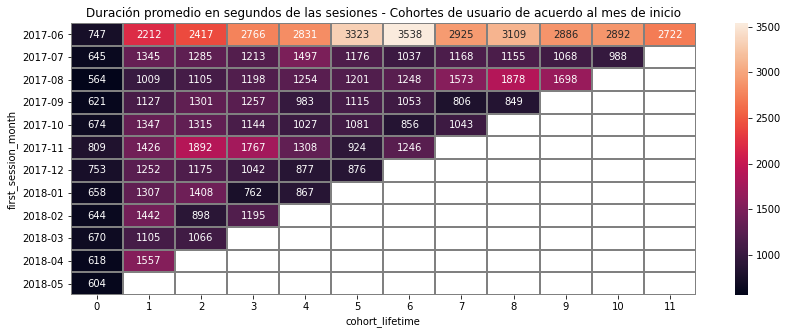

In [63]:
# Mapa de calor para tiempo de cada sesión por usuario
plt.figure(figsize=(14,5))
plt.title('Duración promedio en segundos de las sesiones - Cohortes de usuario de acuerdo al mes de inicio')
sns.heatmap(sessions_per_user_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray')

- Los usuarios que entraron a la plataforma por primera vez en Junio del 2017 muestran una mayor actividad durante todo su ciclo de vida. Pero tal como lo observamos anteriormente, estos valores pueden estar algo inflados ya que solo un cuarto de las sesiones de este cohorte presentan valores superiores a los 1000 segundos.

- El promedio de tiempo mensual el primer mes de actividad es más bajo para los usuarios de todos los cohortes. Esto se puede producir ya que no tienen el conocimiento apropiado del uso de la plataforma o simplemente porque a partir del segundo mes solo quedan los usuarios realmente interesados que aumentan el promedio de duración de las sesiones.

- En líneas generales y dejando de lado los valores atípicos, podemos decir que el tiempo promedio de las sesiones se va reduciendo gradualmente pero sin cambios bruscos.

Tendremos que observar los cambios en cantidad de usuarios para dar acotaciones más acertadas.
 

In [64]:
# Creamos una tabla dinámica para la cantidad de usuarios por cohorte
users_pivot = users_grouped_by_cohorts.pivot_table(
    index='first_session_month',columns='cohort_lifetime', values='uid')

<AxesSubplot:title={'center':'Ciclo de vida de cantidad de usuarios activos - Cohortes de usuario por mes de primera sesión'}, xlabel='cohort_lifetime', ylabel='first_session_month'>

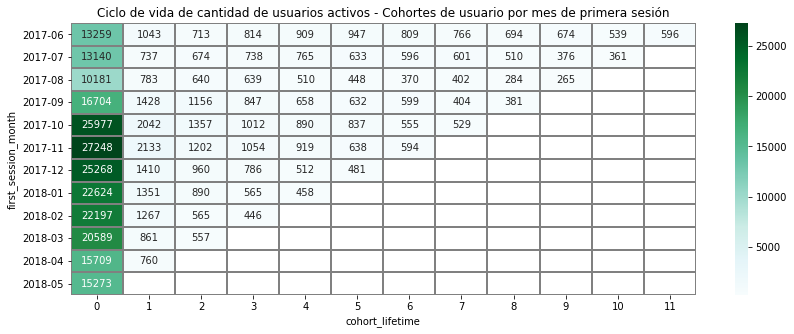

In [65]:
# Creamos un mapa de calor para visualizar los cambios en cantidades de usuario 
plt.figure(figsize=(14,5))
plt.title('Ciclo de vida de cantidad de usuarios activos - Cohortes de usuario por mes de primera sesión')
sns.heatmap(users_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray', cmap='BuGn')

**El mapa de calor muestra los usuarios activos de acuerdo a su mes de llegada y el cómo va cambiando este valor mes a mes. El tono verde se vuelve más oscuro mientras más usuarios activos existen.**

- Son muchos los usuarios que no vuelven después del primer mes de uso.

- Los meses que presentan mayor cantidad de usuarios activos son para los que entraron por primera vez entre octubre y diciembre del año 2017. Esto daría cuenta de que podría tratarse de un factor estacional el que lleguen más usuarios en esas fechas.
- Los demás periodos del ciclo de vida se pierden en el mapa de calor ya que presenta números muy bajos comparados al primer mes.

Vamos a analizar el mapa de mejor manera cambiando los valores máximos y mínimos:

<AxesSubplot:title={'center':'Ciclo de vida de cantidad de usuarios activos - Cohortes de usuario por mes de primera sesión'}, xlabel='cohort_lifetime', ylabel='first_session_month'>

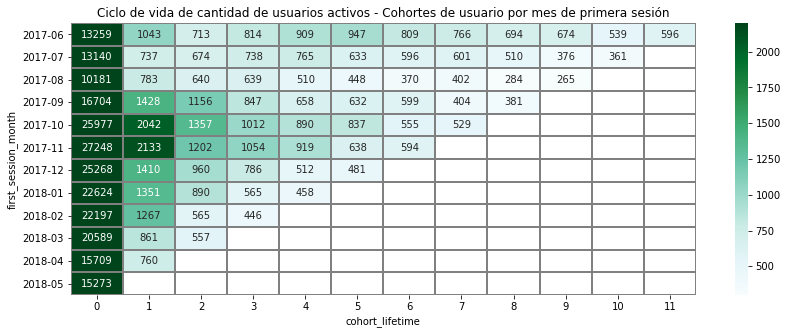

In [66]:
# Creamos un mapa de calor para visualizar los cambios en cantidades de usuario 
plt.figure(figsize=(14,5))
plt.title('Ciclo de vida de cantidad de usuarios activos - Cohortes de usuario por mes de primera sesión')
sns.heatmap(users_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray', cmap='BuGn', vmin=300, vmax=2200)

Ahora podemos ver pequeñas diferencias en los usuarios; aunque el salto es bastante grande respecto al primer mes, hay ciertos patrones que podemos mencionar:

- Los usuarios más antiguos (junio del 2017) en general son los que han demostrado una mayor fidelidad a la plataforma.

- Los usuarios que llegaron entre septiembre y diciembre del 2017, muestran una mayor participación durante los primeros 3 meses.

- El cohorte de agosto de 2017 es el que presenta más baja actividad.

Ya tenemos claridad de los usuarios activos por cohorte de acuerdo a su punto inicial. Cuanto mayor tiempo podamos retener a los usuarios, mayores pueden ser nuestros ingresos potenciales. Calculemos la tasa de retención que tiene nuestra plataforma.

#### Tasa de retención de usuarios

Dependiendo de la naturaleza del tipo de producto/servicio que entregue Y.Afisha, podemos determinar si es necesario formar cohortes semanales para aplicar medidas que van a tener un impacto casi instantáneo en la conducta de los usuarios. Mientras tanto, seguiremos usando cohortes mensuales para aplicar observaciones y sugerencias de estrategias.

La tasa de retención nos mostrará el porcentaje de usuarios que logramos retener por periodo respecto del inicio.

<AxesSubplot:title={'center':'Retención de usuarios de acuerdo a cohortes mensuales'}, xlabel='cohort_lifetime', ylabel='first_session_month'>

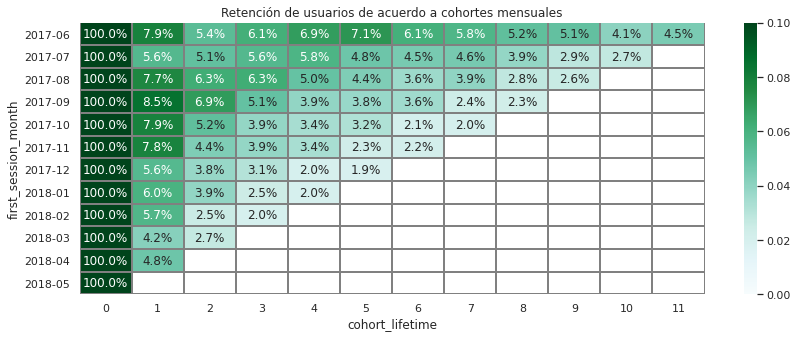

In [67]:
# Usuarios iniciales por cohorte
initial_users_count = users_grouped_by_cohorts[users_grouped_by_cohorts['cohort_lifetime']== 0][['first_session_month', 'uid']]

# Renombramos la columna de cantidad de usuarios 'uid' por 'cohort_user'
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_users'})

# Unimos esta nuebla tabla con 'users_grouped_by_cohorts' con el método merge
users_grouped_by_cohorts = users_grouped_by_cohorts.merge(initial_users_count, on='first_session_month')

# Calculamos la tasa de retención dividiendo la cantidad de usuarios por la cantidad inicial para cada cohorte
users_grouped_by_cohorts['retention'] = users_grouped_by_cohorts['uid'] / users_grouped_by_cohorts['cohort_users']

#Creamos una tabla dinámica
retention_pivot = users_grouped_by_cohorts.pivot_table(
    index='first_session_month', columns='cohort_lifetime', values='retention', aggfunc='sum'
)

#Creamos un mapa de calor
sns.set(style='white')
plt.figure(figsize=(14,5))
plt.title('Retención de usuarios de acuerdo a cohortes mensuales')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='BuGn', vmin=0, vmax=0.1)

- **La mejor tasa de retención la tenemos en el primer mes del ciclo de vida para los usuarios que ingresaron por primera vez en septiembre de 2017, con una retención del 8.5% de los usuarios.** Esto muestra cierta congruencia con las observaciones vistas anteriormente, ya que a partir de este mes, comenzó el incremento de actividad en la plataforma.


- **El cohorte que fue más fiel** a la plataforma corresponde a los usuarios que entraron por primera vez en **junio del 2017**. Es posible que en esa fecha se haya lanzado la plataforma mediante una campaña de marketing.


- A pesar de que en el mes de agosto de 2007 la cantidad de usuarios fue menor que para otros cohortes, la tasa de retención a partir de este mes mejora.


- Algo curioso pasa también para el mes de agosto y septiembre del 2017; si bien su cantidad de usuarios es más baja que los cohortes de fin de año, la tasa de retención que presentan en general es más alta. Los meses de octubre y noviembre presentan una buena tasa de retención el primer mes pero luego bajan considerablemente.


Ya conseguimos algunas características del comportamiento de los usuarios y cuáles son los márgenes que manejamos de retención dentro de un año. Veamos ahora la proporción de usuarios que deja de usar la plataforma.

#### Tasa de cancelación

La tasa de cancelación nos muestra la proporción de usuarios que dejaron de usar la plataforma con el paso del tiempo (comparación de número de usuarios en una determinada etapa con la etapa anterior).

Vamos a calcular la tasa de cancelación de manera porcentual, esto quiere decir, la cantidad de usuarios que dejaron de iniciar sesión en nuestra plataforma de un periodo a otro. 

<AxesSubplot:title={'center':'Tasa de cancelación de acuerdo a cohortes mensuales'}, xlabel='cohort_lifetime', ylabel='first_session_month'>

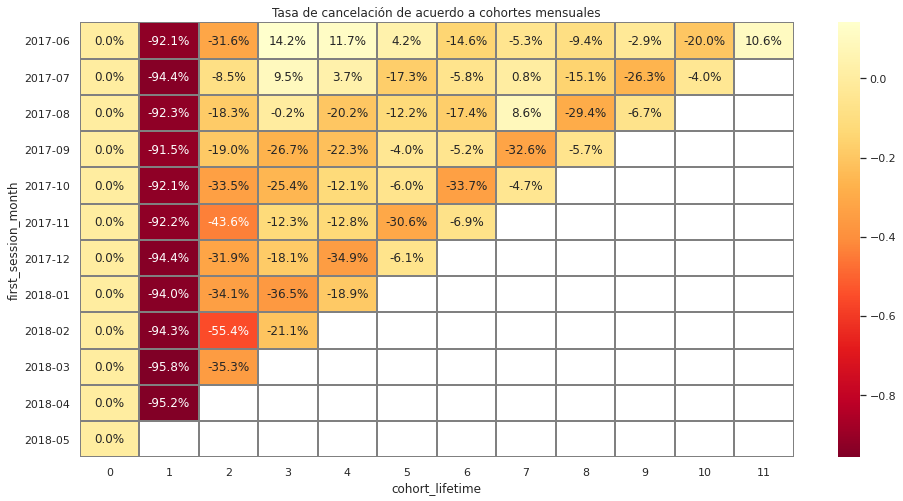

In [68]:
# Creamos la columna 'churn_rate' para calcular los valores de cancelación con el método pct_change
users_grouped_by_cohorts['churn_rate'] = users_grouped_by_cohorts.groupby(['first_session_month'])['uid'].pct_change()

# Creamos una tabla dinámica
churn_pivot = users_grouped_by_cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='churn_rate',
    aggfunc='sum'
)

# Generamos el mapa de calor
sns.set(style='white')
plt.figure(figsize=(16,8))
plt.title('Tasa de cancelación de acuerdo a cohortes mensuales')
sns.heatmap(churn_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='YlOrRd_r')

**El mapa de calor de la tasa de cancelación presenta sus valores más preocupantes en un tono rojizo oscuro. Mientras más claro, demuestra que son periodos de baja o nula cancelación.**

- **La tasa de cancelación al primer mes de uso es bastante alta, supera el 90% para todos los cohortes, alcanzando el peak de cancelación para el primer mes del cohorte de marzo de 2018.**


- Respecto al mes de marzo de 2018 (representado en diagonal en naranja), fue malo para todos los cohortes, teniendo porcentajes de cancelación que van desde el -20% al -55.4% de usuarios respecto a su mes respectivo anterior.


- Al segundo mes del ciclo de vida, la tasa de cancelación no es tan alta como en el primer mes, pero siguen disminuyendo los usuarios al menos una tercera parte de la que disminuyo el periodo anterior, exceptuando a los usuarios que entraron por primera vez desde julio a septiembre del 2017 que tienen una tasa de cancelación un poco más baja.

- Las tasas de cancelación menos agresivas las podemos observar en los siguientes cohortes y periodos:
    
        - Cohorte de usuarios de junio del 2017; meses del ciclo de vida: 3ro, 4to, 5to, 11avo.
        - Cohorte de usuarios de Julio del 2017; meses del ciclo de vida: 3ro, 4to, 7mo.
        - Cohorte de usuarios de Agosto del 2017; meses del ciclo de vida: 7mo.
        
        
   Podemos concluir que **solo los usuarios más antiguos tienen una tasa de cancelación más baja**; y que precisamente los resultados positivos son comunes al tercer y cuarto mes para los cohortes de junio y julio, o al séptimo mes para los cohortes de julio y agosto del 2017. Esto puede dar indicios de que hubo alguna campaña quizás para evitar la salida de los usuarios sobre todo después del tercer mes. Claro que esto solo se aplica para los usuarios más antiguos (previos a septiembre de 2017), ya que desde ese entonces, la tasa de cancelación ha sido más agresiva.
   

**Ya disponemos de varias conclusiones respecto a los usuarios y su actividad dentro de la plataforma. Pero aún nos queda el determinar los dispositivos que utilizan y las fuentes de anuncio de las que provienen.**


#### Actividad de los usuarios de acuerdo al dispositivo con el que entran a Y.Afisha

El dataset de visitas nos mostró que los usuarios usan dos tipos de dispositivo: desktop y touch (computador de escritorio y dispositivo táctil). El procedimiento para hacer la comparativa será el siguiente:

    - Creación de tabla dinámica comparando los usuarios únicos para cada dispositivo en cada mes.
    - Gráfico de la cantidad de usuarios para cada dispositivo en el tiempo.
    - Formación de cohortes de usuario por fecha para visualizar diferencias.
    - Creación de tablas dinámicas para cada dispositivo.
    - Mapas de calor para visualizar diferencias mediante la retención de usuarios dependiendo del dispositivo.

In [69]:
# Agrupamos por tipo de dispositivo y fecha
visits_device_count = visits.groupby(['device', 'session_date_month']).agg({'uid': 'nunique'})
# Pasamos los valores del índice  a una nueva columna
visits_device_count = visits_device_count.reset_index()
# Formateamos a string en formato date dejando solo el mes y año
visits_device_count['session_date_month'] = visits_device_count['session_date_month'].dt.strftime('%Y-%m') 
# Establecemos el nuevo índice
visits_device_count = visits_device_count.set_index('session_date_month')
# Creamos una tabla dinámica para asignar los dispositivos
device_pivot = visits_device_count.pivot_table(index='session_date_month',columns='device', values='uid')


**Nuestra tabla dinámica nos muestra la cantidad de usuarios únicos por dispositivo en cada mes.**

Veamos estos datos mediante un gráfico.

Text(0.5, 0, 'Año y mes')

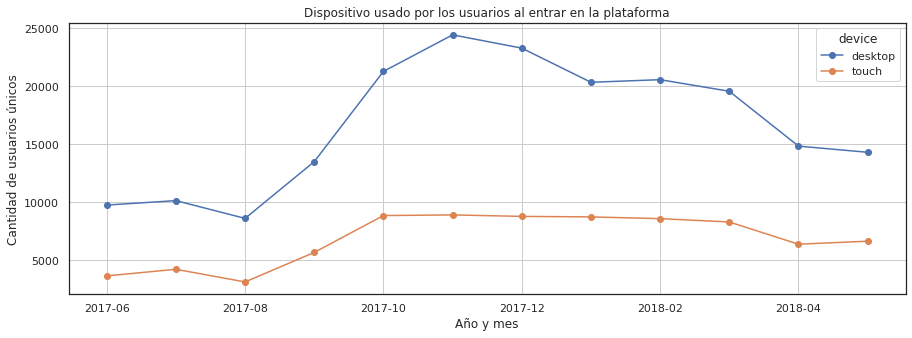

In [70]:
# Generamos el gráfico
device_pivot.plot(y =['desktop', 'touch'], style='-o', title= 'Dispositivo usado por los usuarios al entrar en la plataforma', 
                    grid= True, figsize=(15,5))

plt.ylabel('Cantidad de usuarios únicos')
plt.xlabel('Año y mes')

- **El computador de escritorio viene a ser el dispositivo más popular durante todos los meses**, llegando a duplicar fácilmente el uso en dispositivos touch.


- El comportamiento de las curvas es similar para ambos, exceptuando los meses de noviembre y diciembre en el que se produce un aumento considerable para los computadores de escritorio; en  cambio, para los dispositivos touch la actividad se mantiene similar al mes de octubre.


No hay señales claras de patrones que puedan indicar una preferencia de un dispositivo sobre el otro. Solo podríamos considerar el caso de los meses de noviembre y diciembre del 2017 en que la curva presenta un comportamiento distinto.

Vamos a usar los cohortes de usuario por fecha de primer ingreso para ver si existe alguna diferencia entre estos grupos con respecto al uso de dispositivos.

In [71]:
# Agrupamos los usuarios por cohortes como lo hicimos antes en la tabla dinámica
device_users_grouped = visits.groupby(
    ['first_session_month', 'session_date_month', 'device']).agg({'uid':'nunique'})
# Reseteamos el índice
device_users_grouped = device_users_grouped.reset_index()

#Filtramos por uid mayores a 0 (al incorporar la columna device se agregaron valores vacíos para session_date_month inferiores a first_session_month)
device_users_grouped = device_users_grouped.query('uid > 0')

# Ciclo de vida y ajuste de fechas
# Agregamos el tiempo de vida restando las fechas de sesiones
device_users_grouped['cohort_lifetime'] = (
    device_users_grouped['session_date_month'] - device_users_grouped['first_session_month']
)

# Calculamos el tiempo de vida en meses
device_users_grouped['cohort_lifetime'] = device_users_grouped['cohort_lifetime'] / np.timedelta64(1, 'M')

# Redondeamos a enteros
device_users_grouped['cohort_lifetime'] = (device_users_grouped['cohort_lifetime'].round().astype('int'))

# Formateamos a string en formato date dejando solo el mes y año
device_users_grouped['first_session_month'] = device_users_grouped['first_session_month'].dt.strftime('%Y-%m') 
device_users_grouped['session_date_month'] = device_users_grouped['session_date_month'].dt.strftime('%Y-%m')

#Creamos tablas para cada dispositivo
desktop_users = device_users_grouped.query('device == "desktop"')
touch_users = device_users_grouped.query('device == "touch"')

#Reiniciamos el índice luego de los cambios producidos por el query
desktop_users = desktop_users.reset_index(drop=True)
touch_users = touch_users.reset_index(drop=True)

#Cálculo de tasa de retención
# Usuarios iniciales por cohorte
initial_desktop_count = desktop_users[desktop_users['cohort_lifetime']== 0][['first_session_month', 'uid']]
initial_touch_count = touch_users[touch_users['cohort_lifetime']== 0][['first_session_month', 'uid']]

# Renombramos la columna de cantidad de usuarios 'uid' por 'cohort_user'
initial_desktop_count = initial_desktop_count.rename(columns={'uid': 'cohort_users'})
initial_touch_count = initial_touch_count.rename(columns={'uid': 'cohort_users'})

# Unimos esta nuebla tabla con 'desktop_users' y 'touch_users' con el método merge mediante la columna 'first_session_month'
desktop_users = desktop_users.merge(initial_desktop_count, on='first_session_month')
touch_users = touch_users.merge(initial_touch_count, on='first_session_month')

# Calculamos la tasa de retención dividiendo la cantidad de usuarios por la cantidad inicial para cada cohorte
desktop_users['retention'] = desktop_users['uid'] / desktop_users['cohort_users']
touch_users['retention'] = touch_users['uid'] / touch_users['cohort_users']

#Creamos una tabla dinámica para cada dispositivo
desktop_retention_pivot = desktop_users.pivot_table(index='first_session_month', 
                                                    columns='cohort_lifetime', values='retention', aggfunc='sum'
)

touch_retention_pivot = touch_users.pivot_table(index='first_session_month', 
                                                    columns='cohort_lifetime', values='retention', aggfunc='sum'
)

**Luego de la creación de las dos tablas con sus tasas de retención, mostramos los mapas de calor de cada uno. Primero haremos algunas acotaciones respecto a cada gráfico para finalizar con una comparación de las retenciones de uno y otro.**

<AxesSubplot:title={'center':'Retención de usuarios que usan computador de escritorio de acuerdo a cohortes mensuales '}, xlabel='cohort_lifetime', ylabel='first_session_month'>

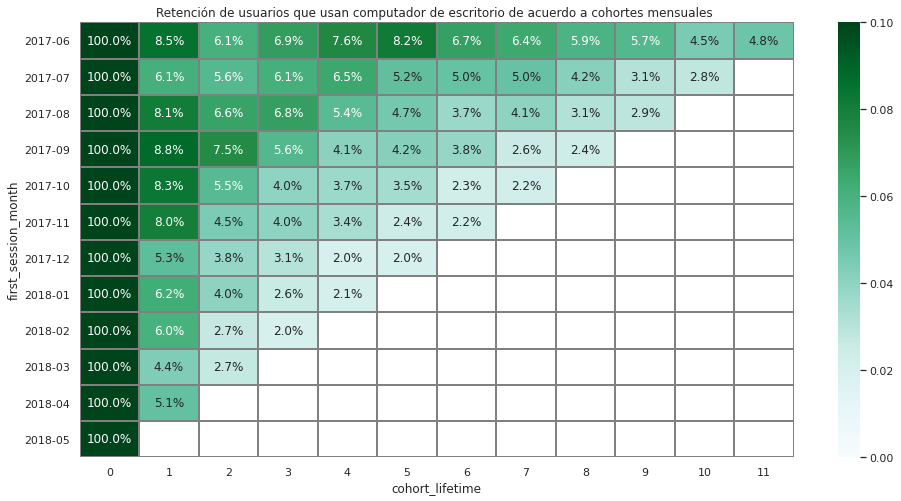

In [72]:
#Creamos un mapa de calor para los usuarios desktop
sns.set(style='white')
plt.figure(figsize=(16,8))
plt.title('Retención de usuarios que usan computador de escritorio de acuerdo a cohortes mensuales ')
sns.heatmap(desktop_retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='BuGn', vmin=0, vmax=0.1)

*Nota: Es importante destacar que ajustamos los valores máximos para mejor visualización ya que la retención en ningún periodo supera el 10%.*

**El mapa de calor indica las zonas oscuras como una mayor retención alcanzada.**

- La retención en de usuarios de computador de escritorio muestra un comportamiento muy similar al general observado anteriormente (mapa de calor de retención general). La tasa de retención es mayor en los primeros cohortes y no coincide con el alza de usuarios que se registra en noviembre de 2017 aproximadamente, donde la retención a nivel general baja y en computador de escritorio también.


Vamos a observar el comportamiento en dispositivos táctiles para verificar alguna diferencia en la retención.


<AxesSubplot:title={'center':'Retención de usuarios que usan dispositivo táctil de acuerdo a cohortes mensuales '}, xlabel='cohort_lifetime', ylabel='first_session_month'>

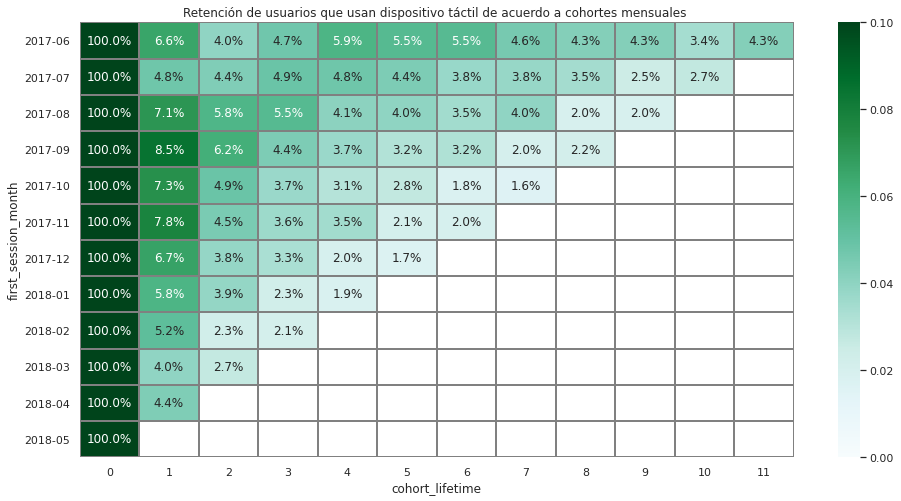

In [73]:
#Creamos un mapa de calor para los usuarios desktop
sns.set(style='white')
plt.figure(figsize=(16,8))
plt.title('Retención de usuarios que usan dispositivo táctil de acuerdo a cohortes mensuales ')
sns.heatmap(touch_retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='BuGn', vmin=0, vmax=0.1)

- **Efectivamente, a nivel general la retención es un poco más baja para todos los cohortes y en todos sus periodos.**

- El comportamiento es similar al general y a la tendencia mostrada en el mapa de calor de los usuarios de computadores de escritorio, pero el nivel de retención es levemente más bajo. 


Todo esto puede indicar que la plataforma para dispositivos móviles no presenta mayor beneficio versus la presentación de un posible sitio web para escritorio por ejemplo. Algunas teorías que podemos hacer respecto a la posible experiencia de uso en versión de escritorio o versión móvil son las siguientes:

    - La versión móvil no presenta ventajas de comodidad. Normalmente los usuarios de dispositivos touch prefieren estos por sobre el computador ya que presta garantías de ser más cómodo y rápido de usar, pero esto no es aprovechado en el sitio.
    
    - La interfaz para dispositivos móviles es la misma que para los de escritorio. Esto puede presentar dificultades al momento de navegar por el sitio de forma táctil.

#### Actividad de los usuarios de acuerdo a la fuente de anuncios de la que provienen

Otro parámetro con el que podemos medir la actividad de las visitas, es la fuente de anuncios de la que provienen los usuarios. Comencemos por ver cuántas fuentes existen:

In [74]:
# Vemos los valores únicos para la columna
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

- Existen 9 fuentes de anuncios, enumeradas del 1 al 10 (sin contar el 8).

Crearemos una tabla para agrupar por 'source_id' tal cual como lo hicimos con los dispositivos.

**Variación de cantidad de usuarios únicos por mes dependiendo de la fuente de anuncios:**

In [75]:
# Agrupamos por tipo de dispositivo y fecha
visits_source_count = visits.groupby(['source_id', 'session_date_month']).agg({'uid': 'nunique'})
# Pasamos los valores del índice  a una nueva columna
visits_source_count = visits_source_count.reset_index()
# Formateamos a string en formato date dejando solo el mes y año
visits_source_count['session_date_month'] = visits_source_count['session_date_month'].dt.strftime('%Y-%m') 
# Establecemos el nuevo índice
visits_source_count = visits_source_count.set_index('session_date_month')
# Creamos una tabla dinámica para asignar los dispositivos
source_pivot = visits_source_count.pivot_table(index='session_date_month',columns='source_id', values='uid')


Veamos gráficamente la cantidad de usuarios mensual de acuerdo a la fuente de anuncios:

Text(0.5, 0, 'Año y mes')

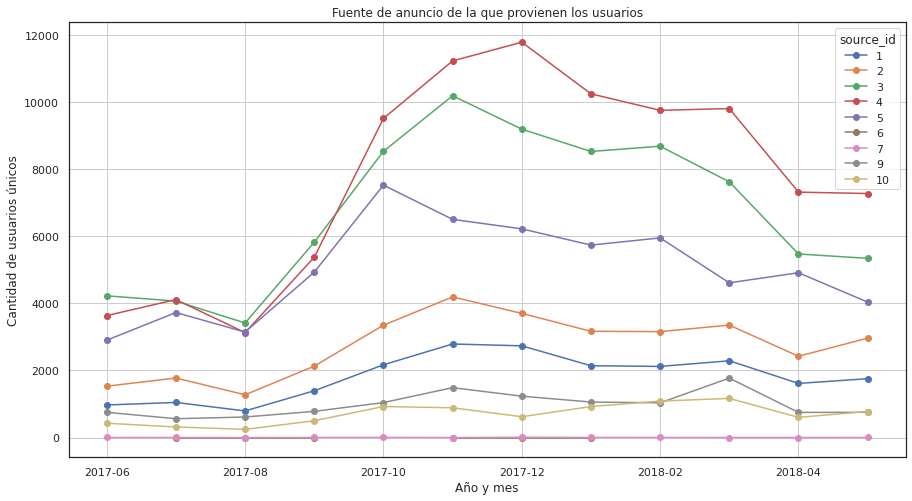

In [76]:
# Generamos el gráfico
source_pivot.plot(style='-o', title= 'Fuente de anuncio de la que provienen los usuarios', 
                    grid= True, figsize=(15,8))

plt.ylabel('Cantidad de usuarios únicos')
plt.xlabel('Año y mes')

- Se diferencian dos grupos de fuentes de anuncios: **los tres más populares (fuentes 3, 4 y 5)** y el resto. Cada grupo tiene un comportamiento distinto. El grupo de fuentes populares comienza en promedio aportando más de 3000 visitadores en junio de 2017, alcanzando el peak en distintos meses pero seguidos. 


    - La fuente 5 alcanza su peak en octubre de 2017 con casi 8 mil usuarios para luego descender gradualmente hasta cerca de los 4 mil usuarios en mayo de 2018.
    - La fuente 3 comienza como la más popular pero alcanza su peak en noviembre de 2017 superando levemente los 10 mil usuarios y quedando en segundo lugar de popularidad. Luego desciende gradualmente hasta llegar a los 5500 usuarios aprox. en mayo de 2018.
    - La fuente 4 alcanza su peak en diciembre de 2017 llegando a alcanzar casi 12 mil usuarios y luego desciente hasta los casi 7500 usuarios usuarios al final del tramo.

- El comportamiento que muestran estas fuentes más populares se hace más vertiginoso desde septiembre de 2017 cuando comienzan a ascender y luego de alcanzar sus respectivos peaks, van descendiendo hasta llegar a tener la mitad de usuarios que tuvieron en su punto máximo.


En cambio, el otro grupo de fuentes de anuncio, presentan un comportamiento más regular a través del tiempo.


- En general muestran un alza desde el mes de septiembre a noviembre para luego disminuir en una proporción menor a lo visto con las fuentes más populares.

- Dentro de este grupo, la fuente número 2 es la que se presenta con mayores usuarios, llegando a superar los 4 mil para finalizar el ciclo con 3 mil aproximadamente.

- Las fuentes 7 y 6 no presentan una curva de crecimiento debido a la muy baja representación.

Veamos a continuación la cantidad de sesiones abiertas por cada fuente para confirmar los números de las fuentes 6 y 7:

In [77]:
# Cantidad de sesiones abiertas por fuente de anuncio
visits['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

Solo se registraron 36 sesiones para la fuente nro. 7 y solo 6 sesiones para la fuente nro. 6.

A modo general, la cantidad de usuarios a través de cada mes responde al comportamiento normal que se ha presentado durante todo el análisis. Los incrementos desde septiembre a diciembre pueden representar un factor estacional. Sin embargo, acá tenemos la diferencia de que se forma una brecha clara para dos grupos de fuentes.

Al separar los usuarios por cohortes mensuales como lo hemos estado haciendo, quizás podemos apreciar otros factores que indiquen alguna preferencia en cierto mes por cierta fuente de anuncios. Consideraremos solo las 3 fuentes con más usuarios para este análisis.

In [78]:
# Agrupamos los usuarios por cohortes como lo hicimos antes en la tabla dinámica
source_users_grouped = visits.groupby(
    ['first_session_month', 'session_date_month', 'source_id']).agg({'uid':'nunique'})
# Reseteamos el índice
source_users_grouped = source_users_grouped.reset_index()
# Ciclo de vida y ajuste de fechas
# Agregamos el tiempo de vida restando las fechas de sesiones
source_users_grouped['cohort_lifetime'] = (
    source_users_grouped['session_date_month'] - source_users_grouped['first_session_month']
)

# Calculamos el tiempo de vida en meses
source_users_grouped['cohort_lifetime'] = source_users_grouped['cohort_lifetime'] / np.timedelta64(1, 'M')
# Redondeamos a enteros
source_users_grouped['cohort_lifetime'] = (source_users_grouped['cohort_lifetime'].round().astype('int'))

# Formateamos a string en formato date dejando solo el mes y año
source_users_grouped['first_session_month'] = source_users_grouped['first_session_month'].dt.strftime('%Y-%m') 
source_users_grouped['session_date_month'] = source_users_grouped['session_date_month'].dt.strftime('%Y-%m')

#Creamos tablas para cada las 3 mejores fuentes de anuncios
source_3_users = source_users_grouped.query('source_id == 3')
source_4_users = source_users_grouped.query('source_id == 4')
source_5_users = source_users_grouped.query('source_id == 5')

#Reiniciamos el índice luego de los cambios producidos por el query
source_3_users = source_3_users.reset_index(drop=True)
source_4_users = source_4_users.reset_index(drop=True)
source_5_users = source_5_users.reset_index(drop=True)

#Creamos una tabla dinámica para cada fuente de anuncios
source_3_users_pivot = source_3_users.pivot_table(index='first_session_month', columns='cohort_lifetime', values='uid')
source_4_users_pivot = source_4_users.pivot_table(index='first_session_month', columns='cohort_lifetime', values='uid')
source_5_users_pivot = source_5_users.pivot_table(index='first_session_month', columns='cohort_lifetime', values='uid')


<AxesSubplot:title={'center':'Usuarios que provienen de la fuente de anuncios 3 de acuerdo a cohortes mensuales'}, xlabel='cohort_lifetime', ylabel='first_session_month'>

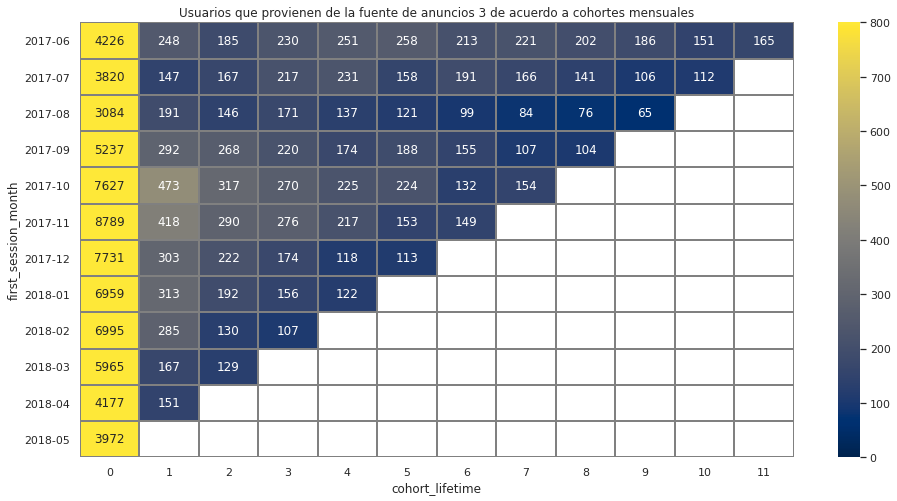

In [79]:
#Creamos un mapa de calor para los usuarios de la fuente de anuncios 3
sns.set(style='white')
plt.figure(figsize=(16,8))
plt.title('Usuarios que provienen de la fuente de anuncios 3 de acuerdo a cohortes mensuales')
sns.heatmap(source_3_users_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray', cmap='cividis', vmin=0, vmax=800)

**El mapa de calor muestra la cantidad de usuarios organizados por cohortes de mes de llegada. El color amarillo representa los valores más altos mientras que el azul los más bajos.**

- El comportamiento de los cohortes es muy similar al visto previamente con otros factores. No hay indicios para algún cohorte de que la fuente de anuncios sea más atractiva para un grupo de usuarios dependiendo de la fecha. Esto nos indica que si sigue el comportamiento habitual, probablemente la fuente de anuncios no haya tenido cambios durante todo el año.

Ahora comparemos el comportamiento con la fuente más popular, la número 4:

<AxesSubplot:title={'center':'Usuarios que provienen de la fuente de anuncios 3 de acuerdo a cohortes mensuales'}, xlabel='cohort_lifetime', ylabel='first_session_month'>

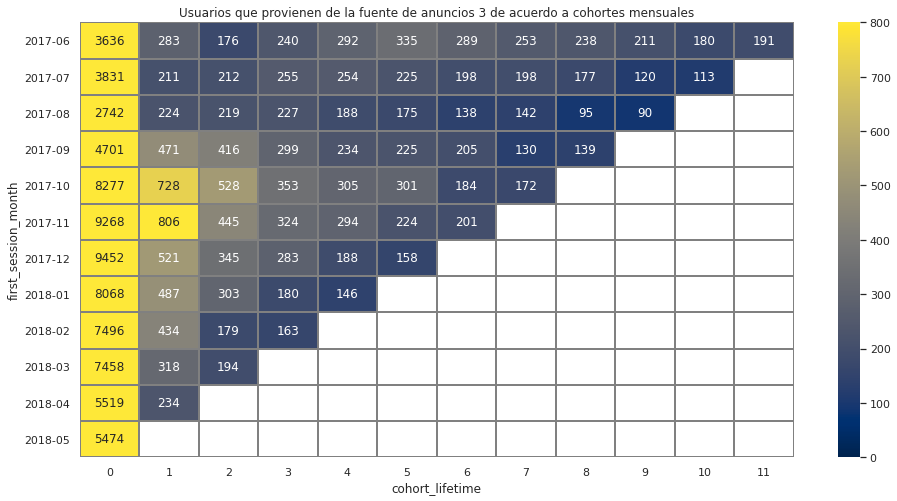

In [80]:
#Creamos un mapa de calor para los usuarios de la fuente de anuncios 4
sns.set(style='white')
plt.figure(figsize=(16,8))
plt.title('Usuarios que provienen de la fuente de anuncios 3 de acuerdo a cohortes mensuales')
sns.heatmap(source_4_users_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray', cmap='cividis', vmin=0, vmax=800)

- La coloración es muy similar respecto a la fuente de anuncios 3, por lo tanto no hay indicios de un comportamiento atípico.

- Los valores alcanzados son más altos y así también lo refleja su coloración un poco más amarillenta. Se presenta como la fuente de anuncios más popular.

Veamos la última fuente de anuncios, la número 5.

<AxesSubplot:title={'center':'Usuarios que provienen de la fuente de anuncios 3 de acuerdo a cohortes mensuales'}, xlabel='cohort_lifetime', ylabel='first_session_month'>

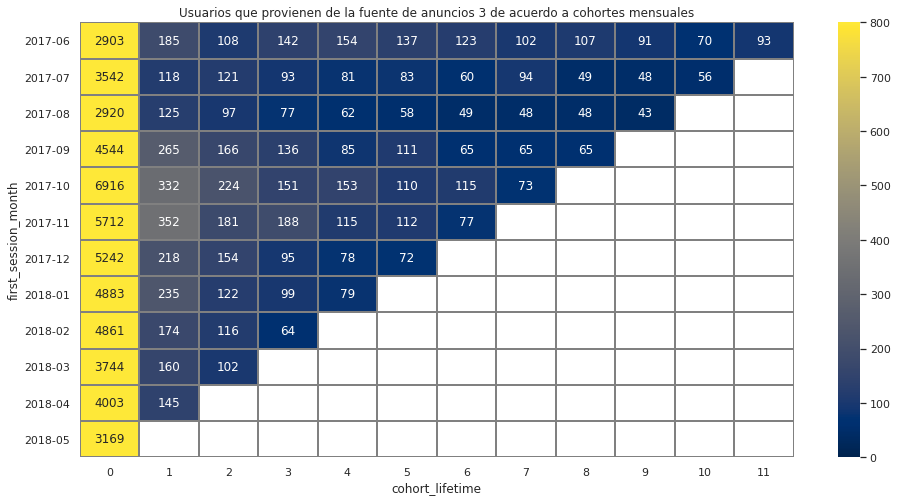

In [81]:
#Creamos un mapa de calor para los usuarios de la fuente de anuncios 5
sns.set(style='white')
plt.figure(figsize=(16,8))
plt.title('Usuarios que provienen de la fuente de anuncios 3 de acuerdo a cohortes mensuales')
sns.heatmap(source_5_users_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray', cmap='cividis', vmin=0, vmax=800)

- La coloración aquí carga más hacia el azul lo que denota que es la fuente de anuncios menos popular de las tres. De hecho es la que más se aleja en valores, ya que la cercanía de las otras fuentes parece ser más evidente.

- El comportamiento en general es muy similar y no hay indicios de algo atípico de acuerdo a los cohortes.


Luego de la visualización por cohortes, podemos concluir que no existen comportamientos atípicos lo que muestra que las fuentes de anuncios se percibieron de la misma forma siempre por todos los cohortes. No hubo rasgos que mostraran un aumento o baja de usuarios relevante por la fuente de anuncios.

#### Conclusiones respecto al producto y visitas alcanzadas

Las preguntas planteadas en la sección anterior fueron respondidas a través de todo el análisis del producto. Detallaremos a continuación las metodologías usadas y las respuestas que nos dan claras señales de algunos comportamientos de los usuarios.

Primero; generamos nuevas columnas relativas a fechas en nuestro dataset 'visits' para llegar al número de usuarios activos por día, semana, mes y año. Los resultados fueron los siguientes:

    Visitas a Y.Afisha y su frecuencia aproximada
    - Diariamente: 907 usuarios.
    - Semanalmente: 5716 usuarios.
    - Mensualmente: 23228 usuarios.

Segundo; para obtener la frecuencia con la que vuelven los usuarios, calculamos el factor de adherencia. Los resultados fueron los siguientes:

    - Adherencia semanal: 15.88%
    - Adherencia mensual: 3.90%

La frecuencia con la que regresan los usuarios es relativamente baja. Solo una sexta parte de los usuarios vuelven dentro de la misma semana.

Tercero; generamos una tabla dinámica para calcular las sesiones por usuario y descubrimos que **en promedio cada usuario pasa solo una sesión al mes.** Respecto a las **sesiones totales iniciadas diariamente, en promedio son 987; siendo 908 de estas sesiones de un único usuario. ** 


Cuarto; la duración de sesiones no tenía una distribución uniforme para los usuarios, por lo tanto optamos por aplicar la moda para tener el valor de la duración promedio de la sesión por usuario. El resultado fue que **en promedio las sesiones duran 1 minuto.** Este valor puede ser bastante bajo si consideramos también que ingresan en promedio solo una vez al mes.


Para analizar en detalle estos números bajos, creamos cohortes de usuario por mes de primera sesión, aplicamos tablas dinámicas y generamos mapas de calor.

**Respecto a los cohortes podemos dar las siguientes conclusiones:**


**Cantidad de usuarios:**
-  Los meses en que ingresaron más usuarios nuevos corresponden al periodo desde octubre a diciembre del 2017; luego de una crecida en el mes de septiembre para luego comenzar un declive gradual en diciembre de ese mismo año. **Esto puede representar un comportamiento estacional en los usuarios, es posible que esa temporada sea alta para nuestra plataforma.**

- Hay una drástica caída en la cantidad de usuarios activos luego del primer mes.

- Los usuarios más antiguos (junio del 2017) son los que han demostrado mayor lealtad con la plataforma.

- Los cohortes que demostraron mayor presencia los primeros meses, fueron de los usuarios que llegaron entre septiembre y diciembre del 2017.

**Retención y cancelación de usuarios:**

- En lineas generales la retención de cualquier periodo no supera el 10% de usuarios respecto a los iniciales para cada cohorte.

- El cohorte con mayor retención corresponde al primero (junio del 2017) posiblemente por alguna campaña de lanzamiento.

- Si bien los usuarios que llegaron en agosto y septiembre no tienen las cifras más altas, la retención fue mayor en este periodo.

- La tasa de cancelación es bastante alta el primer mes, superando el 90% en todos los cohortes.

- Los primeros tres cohortes presentan periodos con las tasas de cancelación más baja; esto puede deberse a publicidad u algo atractivo para los usuarios específicamente al tercer, cuarto o séptimo mes.


**Respecto a los dispositivos:**

- El computador de escritorio es ampliamente preferido por sobre los dispositivos táctiles.

- Si bien el comportamiento de cantidad de usuarios es proporcionalmente similar, en los meses de noviembre y diciembre se destaca una crecida en usuarios de computador de escritorio.

- A nivel de cohortes, se ve un comportamiento similar que en el general.

- La tasa de retención para usuarios de dispositivos táctiles es más baja que para usuarios de computador. Esto puede indicar que no representa mayor comodidad el usar un dispositivo móvil por sobre el computador. Puede que la interfaz sea prácticamente igual en ambas o haya sido desarrollada solo para PC, generando un conflicto en usuarios móviles a la hora de usar el sistema táctil y navegar con facilidad por el sitio.


**Respecto a las fuentes de anuncio:**

- Los registros presentan 9 fuentes de anuncios de las cuales se forman 3 grupos claramente marcados:

    - Los más populares: fuentes 3, 4 y 5.
    - Los de nivel medio: fuentes 1, 2, 9, 10.
    - Los que presentan muy pocos registros: fuentes 6 y 7.
    
    
- Las fuentes más populares mantienen márgenes de 3 mil a 12 mil usuarios por mes. Mantienen un patrón de crecimiento y declive muy similar; con crecidas desde septiembre hasta diciembre del 2017. Luego del peak, pueden bajar a la mitad de usuarios alcanzados.
    
- La fuente más popular es la 4, de ella provienen hasta 12 mil usuarios en diciembre de 2017.

- Las fuentes de nivel medio tienen un comportamiento similar y es bastante regular comparado a las más pupulares. Se mantienen bajo los 4 mil usuarios por mes y no suelen variar entre cada periodo.

- Las fuentes menos populares tienen muy pocos registros, las que no superan las 50 sesiones iniciadas en total.

Se realizó un análisis por cohortes de las fuentes más populares y se llegó a la conclusión de que no existen indicios de un comportamiento atípico para algún cohorte en ninguna de las tres fuentes de anuncios. Todas siguen el mismo patrón que se ha visto en análisis previo como el de los dispositivos o el mapa de calor general para los usuarios totales. Esto puede dar cuenta de que las fuentes de anuncio no han variado o no han generado un impacto significativo que pueda afectar la preferencia de los usuarios.


### Análisis de datos: información de las ventas

Ya hemos observado el comportamiento de los usuarios de acuerdo al ingreso a la plataforma y la duración de sus sesiones en la misma. Además, observamos los dispositivos que utilizan para acceder y a través de qué fuente de anuncios lo hacen. Ahora resulta importante determinar los pedidos que hagan en nuestro sitio; esto nos dará información vital para visualizar (luego de evaluar los costos) qué tan próspero es el negocio y cuáles son los puntos más fuertes del mismo.


Para analizar las ventas, primero trabajarémos sobre la información entregada en el segundo dataset; luego, unirémos la información de las columnas 'buy_ts' y 'revenue' mediante los datos de 'uid'.

- ¿Cuándo comienzan a comprar las personas? (Importante observar el tiempo entre start_ts y buy_ts)
- ¿Qué canal de marketing registra mayores ventas?
- ¿Cuántos pedidos se hacen en los periodos más rentables? ¿Cuántos se hacen en los menos?
- ¿Cuál es el monto promedio de las compras?
- ¿Cuánto dinero traen los clientes?

#### Fecha del primer pedido

En el dataset 'orders' vamos a agrupar los pedidos de cada cliente y buscarémos cuál fue el primero que realizaron.

In [82]:
# Creamos una variable para alojar la primera fecha de pedido para cada usuario
first_order_date_by_uid = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_uid

uid
313578113262317        2018-01-03 21:51:00
1575281904278712       2017-06-03 10:13:00
2429014661409475       2017-10-11 18:33:00
2464366381792757       2018-01-28 15:54:00
2551852515556206       2017-11-24 10:14:00
                               ...        
18445147675727495770   2017-11-24 09:03:00
18445407535914413204   2017-09-22 23:55:00
18445601152732270159   2018-03-26 22:54:00
18446156210226471712   2018-02-18 19:34:00
18446167067214817906   2017-10-17 10:16:00
Name: buy_ts, Length: 36523, dtype: datetime64[ns]

Conseguimos las fechas del primer pedido para 36523 usuarios. Si recordamos la información de los datos de este dataset, existen 50415 registros (pedidos), esto quiere decir que varios usuarios tienen que haber hecho más de un pedido.

Vamos a cambiar el nombre de la serie a 'first_order_date' para efectos de orden y unión con otras tablas.

In [83]:
# Cambio de nombre de la Serie
first_order_date_by_uid.name = 'first_order_date'

# Unimos con el dataset orders mediante el método join
orders = orders.join(first_order_date_by_uid, on='uid')


Ya tenemos actualizada la tabla orders con una columna que designa la fecha de primera compra correspondiente a cada registro/usuario. Ahora, crearemos dos columnas; una para establecer el mes de la primera fecha de compra y otro, para marcar el mes de la orden correspondiente.

In [84]:
# Creamos columna para el mes de la primera compra
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
# Creamos columna para mes del pedido
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

Agruparemos los datos por cohortes mensuales de acuerdo al primer pedido que realizan los usuarios:

In [85]:
cohort_orders_grouped = orders.groupby('first_order_month').agg({'uid':'nunique', 'revenue':'sum'})
cohort_orders_grouped

,uid,revenue
first_order_month,,
2017-06-01,2023,24031.69
2017-07-01,1923,16127.92
2017-08-01,1370,11606.26
2017-09-01,2581,34676.32
2017-10-01,4340,27603.45
2017-11-01,4081,26098.99
2017-12-01,4383,33485.74
2018-01-01,3373,16663.13
2018-02-01,3651,16750.50


De esta tabla podemos sacar algunas conclusiones de los usuarios agrupados mensualmente que realizaron compras en el sitio. Realizaremos algunos gráficos para ver de mejor manera los cambios que van mostrando los clientes tanto en cantidad de personas que realizaron su primera compra y valor total que aportaron también estos nuevos clientes.

#### Pedidos distribuidos en cohortes de usuarios nuevos mensuales

**Cantidad de usuarios nuevos por mes que realizaron compras en el sitio:**

Text(0.5, 0, 'Año y mes')

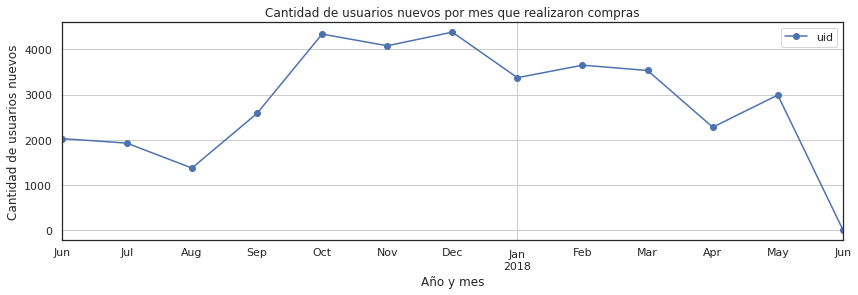

In [86]:
# Generamos el gráfico
cohort_orders_grouped.plot(y='uid',style='-o', title= 'Cantidad de usuarios nuevos por mes que realizaron compras', 
                    grid= True, figsize=(14,4))

plt.ylabel('Cantidad de usuarios nuevos')
plt.xlabel('Año y mes')

- El gráfico de compras por nuevos usuarios es coherente con el comportamiento general de la actividad de los usuarios visto previamente.


- Desde septiembre comienza el alza de usuarios nuevos que realizan compras; en octubre y diciembre alcanzan sus puntos más altos llegando a **superar los 4000 usuarios nuevos que realizan compras**; luego, comienza un descenso que se estabiliza desde enero hasta marzo, pero teniendo aproximadamente 1000 usuarios nuevos menos que en su punto máximo. Ya desde abril no vuelven a superar los 3000 y cae drásticamente en junio al tener solo un usuario nuevo que realiza compras.

*Nota: respecto al único comprador de junio, revisaremos al detalle si esto se produjo por la fecha de recopilación de datos.*

**Ingresos totales provenientes de nuevos usuarios cada mes:**

Text(0.5, 0, 'Año y mes')

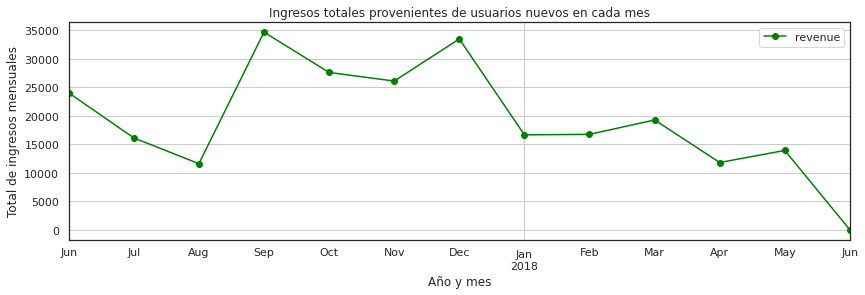

In [87]:
# Generamos el gráfico
cohort_orders_grouped.plot(y='revenue',style='-o', title= 'Ingresos totales provenientes de usuarios nuevos en cada mes', 
                    grid= True, color='green', figsize=(14,4))

plt.ylabel('Total de ingresos mensuales')
plt.xlabel('Año y mes')

- Un factor importante para la compañía, los ingresos totales mensuales por nuevos clientes, presenta características distintas a las vistas previamente.


- **El mes de septiembre figura como el de mayores ingresos, llegando a la cifra de 35 mil mensual.** Esperaríamos que los meses de octubre y noviembre fueran más altos ya que a nivel general, es en estos meses cuando aumenta la actividad de los usuarios y de hecho, son meses en que existen más usuarios nuevos haciendo compras. Pero al parecer, en septiembre los usuarios gastan mucho más en nuestro sitio.


- Diciembre es un mes en que se retoma el alza (después de la baja de ventas en octubre y noviembre) pero luego tendría una drástica caída para los meses siguientes, bajando desde ingresos totales por sobre 30 mil a ingresos totales bajo los 20 mil.


*Nota: se repite la caída para el mes de junio de 2018 por el posible factor que fue acotado con anterioridad. Lo revisaremos a continuación*

In [88]:
# Visualizamos todas los pedidos hechos en junio de 2018
orders[orders['order_month'] == '2018-06-01']

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06-01 00:02:00,2018-06-01,2018-06-01


Efectivamente, solo tenemos un registro para ese mes por lo tanto no podemos utilizarlo de forma comparativa.

Ya teniendo el panorama general de cantidad de usuarios nuevos por mes que realizan compras y los totales mensuales por estos nuevos usuarios, sería interesante ver el comportamiento per cápita; es decir, cuánto nos dejan en promedio cada nuevo usuario mes a mes.

Agruparemos por cohortes como lo hemos venido haciendo y luego dividiremos el total mensual en la cantidad de usuarios correspondiente al cohorte.

#### Promedio de compras por usuario y ciclo de vida del cohorte

Primero, agrupamos por cohortes de acuerdo al primer mes de compra y por mes de compra de la orden; luego, creamos una columna para calcular los ingresos por usuario.

In [89]:
# Agrupamos por mes de primera compra y mes del pedido
orders_by_cohort = orders.groupby(['first_order_month', 'order_month']).agg({'uid':'nunique','revenue':'sum'})

# Creamos una columna para ingresos por usuario
orders_by_cohort['revenue_per_user'] = orders_by_cohort['revenue'] / orders_by_cohort['uid']

orders_by_cohort

uid   revenue  revenue_per_user
first_order_month order_month                                  
2017-06-01        2017-06-01   2023   9557.49          4.724414
                  2017-07-01     61    981.82         16.095410
                  2017-08-01     50    885.34         17.706800
                  2017-09-01     54   1931.30         35.764815
                  2017-10-01     88   2068.58         23.506591
...                             ...       ...               ...
2018-03-01        2018-05-01     58   1114.87         19.221897
2018-04-01        2018-04-01   2276  10600.69          4.657597
                  2018-05-01     69   1209.92         17.535072
2018-05-01        2018-05-01   2988  13925.76          4.660562
2018-06-01        2018-06-01      1      3.42          3.420000

[79 rows x 3 columns]

Crearemos una tabla dinámica a partir del ciclo de vida para visualizar todos los datos de forma más ordenada:

<AxesSubplot:title={'center':'Ingresos por usuario de acuerdo al mes de ciclo de vida de cada cohorte '}, xlabel='cohort_lifetime', ylabel='first_order_month'>

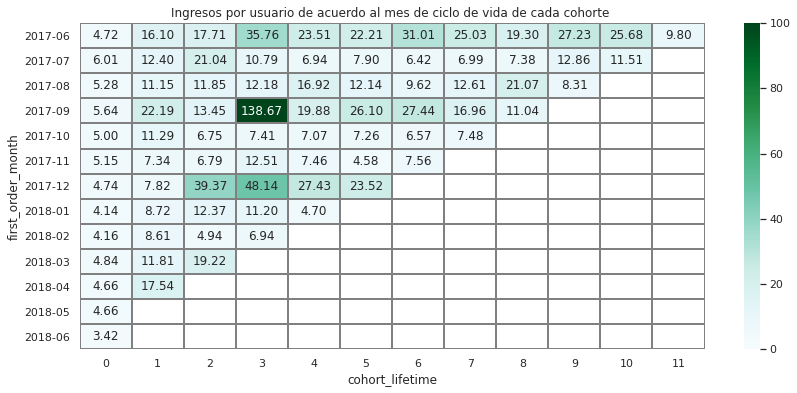

In [90]:
# Tabla dinámica para ingresos por usuario
orders_by_cohort = orders_by_cohort.reset_index()

# Ciclo de vida de los cohortes
orders_by_cohort['cohort_lifetime'] = (orders_by_cohort['order_month'] - orders_by_cohort['first_order_month'])
# Calculamos el tiempo de vida en meses
orders_by_cohort['cohort_lifetime'] = orders_by_cohort['cohort_lifetime'] / np.timedelta64(1, 'M')
# Redeondeamos a entero
orders_by_cohort['cohort_lifetime'] = (orders_by_cohort['cohort_lifetime'].round().astype('int'))
# Formateamos a string en formato date dejando solo el mes y año
orders_by_cohort['first_order_month'] = orders_by_cohort['first_order_month'].dt.strftime('%Y-%m')


#Creamos una tabla dinámica para visualizar las variaciones
revenue_per_user_pivot = orders_by_cohort.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue_per_user',
    aggfunc='mean'
)

# Visualizamos la tabla en un mapa de calor
sns.set(style='white')
plt.figure(figsize=(14,6))
plt.title('Ingresos por usuario de acuerdo al mes de ciclo de vida de cada cohorte ')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap='BuGn', vmin=0, vmax=100)


**El mapa de calor describe el gasto promedio en que incurren los usuarios en la plataforma. Estos usuarios están agrupados en cohortes de acuerdo al mes de su primera compra. El tono verde oscuro representa cifras más altas.**

- Los usuarios que presentan en general un nivel más alto de compras, son los del primer cohorte; es decir, los usuarios que realizaron su primera compra en junio de 2017. Si bien el primer mes no comenzó con la mejor cifra (comparandolo con otros cohortes), tuvo un drástico ascenso hacia el tercer mes (septiembre 2017) para mantener cifras sobre el valor de 20 por usuario los meses siguientes. El último mes (mayo 2018) se aprecia una drástica caída y llega por debajo de los 10 por usuario.

- El promedio más alto por usuario lo alcanza el cohorte que hizo su primera compra en septiembre de 2017. Llega a alcanzar una media de **138.67 por usuario en diciembre de 2017.** Luego bajaría drásticamente a 20 en enero de 2018 para luego terminar en mayo con un valor de 11 por usuario.


- Otro cohorte a destacar es el de usuarios de diciembre de 2017; para su segundo y tercer mes (febrero y marzo del 2018) su gasto promedio se eleva hasta alcanzar márgenes entre 40 y 50 aproximadamente por usuario. Luego desciende pero se mantiene sobre los 20 por usuario.


En líneas generales podemos concluír que hay tres cohortes que tienen un **mejor comportamiento de compra** durante su ciclo de vida: los usuarios de **junio, septiembre y diciembre de 2017.**

Por lo general, **a partir del segundo mes se presenta un alza en el desembolso por usuario y continúa en ascenso hacia el tercer mes**; sin embargo, hay ciertos cohortes que no presentan mucha regularidad y sus cifras son bajas, como por ejemplo: julio, octubre y noviembre de 2017, y todos los cohortes del 2018.



Con los gráficos estudiados previamente ya tenemos información de patrones de compra que pueden tener los distintos cohortes y cuánto desembolsan en promedio mes a mes; pero, *¿Cuándo tardan realmente en comprar desde la primera vez que inician alguna sesión?*

Para responder esta pregunta, tendremos que comparar la columna *start_ts* del primer dataset con *buy_ts* del segundo.

#### Tiempo que tardan los usuarios en realizar alguna compra

Vamos a crear nuevos dataset a partir de orders y visit; solo dejaremos las columnas que necesitamos: las que contienen la información de primera sesión y primera compra.

Luego uniremos mediante el método merge para finalmente eliminar usuarios duplicados y establecer las relaciones que necesitamos.


In [91]:
# Creamos datasets con las columnas que necesitamos
orders_timer = orders[['uid', 'first_order_date', 'first_order_month']]
visits_timer = visits[['uid', 'first_session_date','first_session_month']]

# Unimos los dataset en uno nuevo llamado conversion_time
conversion_time = visits_timer.merge(orders_timer, on='uid')
conversion_time.head()

,uid,first_session_date,first_session_month,first_order_date,first_order_month
0,16174680259334210214,2018-03-09 20:05:00,2018-03-01,2018-03-09 20:25:00,2018-03-01
1,16174680259334210214,2018-03-09 20:05:00,2018-03-01,2018-03-09 20:25:00,2018-03-01
2,16007536194108375387,2017-09-03 21:35:00,2017-09-01,2017-09-04 12:46:00,2017-09-01
3,16007536194108375387,2017-09-03 21:35:00,2017-09-01,2017-09-04 12:46:00,2017-09-01
4,16007536194108375387,2017-09-03 21:35:00,2017-09-01,2017-09-04 12:46:00,2017-09-01


Este procedimiento tiene que haber generado muchos duplicados, como por ejemplo el que se aprecia en estos primeros índices. 

Vamos a eliminar los duplicados:

In [92]:
# Eliminamos los duplicados y reseteamos el índice
conversion_time = conversion_time.drop_duplicates().reset_index(drop=True)

# Vemos la nueva cantidad de la tabla
len(conversion_time)

36523

Este número corresponde al total de usuarios que han hecho compras. Debería ser el mismo que los usuarios únicos del dataset 'orders'. Comprobamos:

In [93]:
# Usuarios únicos de orders
orders['uid'].nunique()

36523

Ahora vamos a crear una nueva columna para nuestro dataset nuevo. En ella estableceremos la diferencia entre el tiempo de primer inicio de sesión y la primera compra por usuario:

In [94]:
conversion_time.head()

,uid,first_session_date,first_session_month,first_order_date,first_order_month
0,16174680259334210214,2018-03-09 20:05:00,2018-03-01,2018-03-09 20:25:00,2018-03-01
1,16007536194108375387,2017-09-03 21:35:00,2017-09-01,2017-09-04 12:46:00,2017-09-01
2,8056418121947262981,2017-06-04 14:17:00,2017-06-01,2017-06-25 08:54:00,2017-06-01
3,18188358787673499603,2018-02-10 12:17:00,2018-02-01,2018-02-12 19:48:00,2018-02-01
4,2307401184189569202,2017-09-23 23:27:00,2017-09-01,2017-09-27 09:23:00,2017-09-01


In [95]:
# Agregamos el tiempo en que demoran en convertirse en clientes
conversion_time['conversion_full_time'] = (conversion_time['first_order_date'] - conversion_time['first_session_date'])

# Creamos una columna para tener solo los días, sin horas
conversion_time['conversion_days'] = conversion_time['conversion_full_time'] / np.timedelta64(1, 'D')

# Redondeamos la cifra
#conversion_time['conversion_days'] = conversion_time['conversion_days'].round()

#Vemos como queda la tabla
conversion_time.head(10)

,uid,first_session_date,first_session_month,first_order_date,first_order_month,conversion_full_time,conversion_days
0,16174680259334210214,2018-03-09 20:05:00,2018-03-01,2018-03-09 20:25:00,2018-03-01,0 days 00:20:00,0.013889
1,16007536194108375387,2017-09-03 21:35:00,2017-09-01,2017-09-04 12:46:00,2017-09-01,0 days 15:11:00,0.632639
2,8056418121947262981,2017-06-04 14:17:00,2017-06-01,2017-06-25 08:54:00,2017-06-01,20 days 18:37:00,20.775694
3,18188358787673499603,2018-02-10 12:17:00,2018-02-01,2018-02-12 19:48:00,2018-02-01,2 days 07:31:00,2.313194
4,2307401184189569202,2017-09-23 23:27:00,2017-09-01,2017-09-27 09:23:00,2017-09-01,3 days 09:56:00,3.413889
5,4499746016005494365,2017-10-23 12:49:00,2017-10-01,2017-11-16 14:04:00,2017-11-01,24 days 01:15:00,24.052083
6,15857957287537270437,2017-09-22 21:16:00,2017-09-01,2018-03-12 23:17:00,2018-03-01,171 days 02:01:00,171.084028
7,15763368622958393183,2017-11-06 09:52:00,2017-11-01,2018-03-06 18:33:00,2018-03-01,120 days 08:41:00,120.361806
8,15868686231870595097,2018-03-27 16:18:00,2018-03-01,2018-03-27 19:45:00,2018-03-01,0 days 03:27:00,0.143750
9,9419370217043167984,2017-09-14 10:31:00,2017-09-01,2017-10-03 11:02:00,2017-10-01,19 days 00:31:00,19.021528


**Ya tenemos una tabla ordenada con la cantidad de días que los usuarios tardaron en comprar luego de haber iniciado sesión por primera vez en nuestra plataforma.**

Primero, veamos a nivel general cómo andan los números de la cantidad de días de conversión. Luego, agruparemos en cohortes de usuario para ver si muestran un comportamiento distinto dependiendo de la fecha en que hayan llegado a la plataforma.

In [96]:
# Estadísticas de los días de conversión de todos los usuarios
conversion_time['conversion_full_time'].describe()

count                         36523
mean     16 days 21:40:10.550064343
std      47 days 01:44:46.481416776
min                 0 days 00:00:00
25%                 0 days 00:04:00
50%                 0 days 00:16:00
75%                 2 days 00:17:00
max               363 days 07:04:00
Name: conversion_full_time, dtype: object

De un total de 36523 usuarios que realizaron una compra, las estadísticas relativas al tiempo son las siguientes:

- La mediana es de solo 16 minutos, esto quiere decir que **al menos la mitad de los usuarios que compraron algo, lo hicieron solo 16 minutos después de haber iniciado sesión por primera vez.**


- La media tiende a 16 días producto de una alta desviación estándar causada por valores atípicos.


- **Al menos un 25% de los usuarios tarda más de 2 días en realizar una compra, mientras que otro 25% se demora solo 4 minutos.**


- El tiempo máximo que demoró un cliente en hacer alguna compra fue de casi un año.


- Existen valores mínimos de 0, lo cual resulta extraño ya que significa que coíncide el valor de inicio de sesión por primera vez con el tiempo de la primera compra.


Examinaremos estos valores mínimos al detalle:

In [97]:
# Filtro de valores de diferencia de tiempo igual a 0
conversion_time.query('conversion_full_time == "0 days 00:00:00"')

,uid,first_session_date,first_session_month,first_order_date,first_order_month,conversion_full_time,conversion_days
33,14190261731932459700,2018-02-12 17:23:00,2018-02-01,2018-02-12 17:23:00,2018-02-01,0 days,0.0
145,16893204926331313613,2017-07-07 20:24:00,2017-07-01,2017-07-07 20:24:00,2017-07-01,0 days,0.0
146,5643980081168402078,2017-11-27 20:19:00,2017-11-01,2017-11-27 20:19:00,2017-11-01,0 days,0.0
155,3880307572277982999,2017-10-24 12:48:00,2017-10-01,2017-10-24 12:48:00,2017-10-01,0 days,0.0
168,8227366664006369899,2017-12-20 20:59:00,2017-12-01,2017-12-20 20:59:00,2017-12-01,0 days,0.0
...,...,...,...,...,...,...,...
36490,427056382260352162,2018-02-01 20:36:00,2018-02-01,2018-02-01 20:36:00,2018-02-01,0 days,0.0
36495,2139567825702884754,2017-11-01 04:26:00,2017-11-01,2017-11-01 04:26:00,2017-11-01,0 days,0.0
36497,13286203327371559009,2018-02-16 20:37:00,2018-02-01,2018-02-16 20:37:00,2018-02-01,0 days,0.0
36503,15112721427745549855,2017-10-05 18:13:00,2017-10-01,2017-10-05 18:13:00,2017-10-01,0 days,0.0


**Existen 2455 usuarios que registran un mismo tiempo de inicio de sesión por primera vez con un mismo tiempo de primera compra.** Esto puede tratarse de algún error de la plataforma a la hora de registrar el tiempo de compra posiblemente.

Considerando que la duración promedio es de 16 minutos, agruparemos a los usuarios por cohortes de primera llegada a nuestra plataforma (primera sesión). Veremos si cambia el tiempo hasta la compra dependiendo del mes en el que hayan llegado.

In [98]:
# Ocupamos la mediana debido a la presencia de valores atípicos que incrementan considerablemente la desviación estándar
conversion_time_by_cohorts = conversion_time.groupby(['first_session_month']).agg({'uid':'nunique', 'conversion_days':'median'})

# Creamos una columna para visualizar el tiempo en minutos
conversion_time_by_cohorts['user_to_client'] = conversion_time_by_cohorts['conversion_days'] * np.timedelta64(1, 'D')

conversion_time_by_cohorts


,uid,conversion_days,user_to_client
first_session_month,,,
2017-06-01,2923,0.016667,0 days 00:24:00
2017-07-01,2458,0.018056,0 days 00:25:59.999999999
2017-08-01,1721,0.013889,0 days 00:20:00
2017-09-01,3058,0.016667,0 days 00:24:00
2017-10-01,4678,0.011806,0 days 00:17:00
2017-11-01,4262,0.020833,0 days 00:30:00
2017-12-01,4074,0.012500,0 days 00:18:00
2018-01-01,3119,0.010417,0 days 00:15:00
2018-02-01,3186,0.008333,0 days 00:12:00


**La tabla nos muestra el tiempo medio que tardaron los usuarios en convertirse en clientes luego de iniciar sesión por primera vez. Los usuarios se agrupan por cohortes de acuerdo al mes de llegada.**

Veamos esta información en un gráfico:

Text(0.5, 0, 'Mes y año')

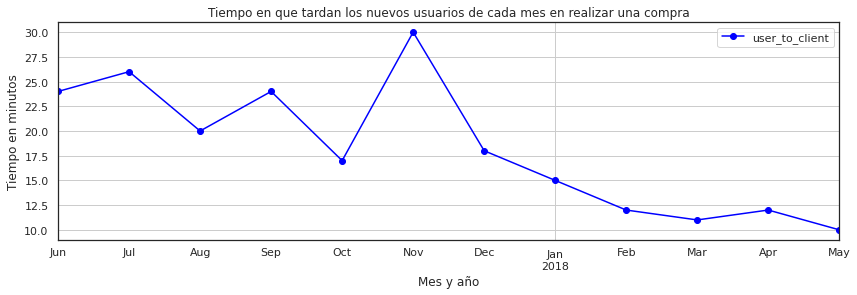

In [99]:
# Como sabemos que las medianas solo se expresan en minutos, cambiamos el formato
conversion_time_by_cohorts['user_to_client'] =(
    conversion_time_by_cohorts['user_to_client'] / np.timedelta64(1, 'm')).round().astype('int')

# Generamos el gráfico
conversion_time_by_cohorts.plot(y='user_to_client',style='-o', 
                                title= 'Tiempo en que tardan los nuevos usuarios de cada mes en realizar una compra', 
                                grid= True, color='blue', figsize=(14,4))

plt.ylabel('Tiempo en minutos')
plt.xlabel('Mes y año')

 Si bien no hay mayores diferencias ya que los márgenes de tiempo van entre los 10 y 30 minutos en promedio, es importante destacar que **en general son tiempos bajos.** Que los usuarios que entren por primera vez y realicen su primera compra, transcurran **no más de 30 minutos**, habla de que el **tiempo de decisión es relativamente corto.** Esto puede ser debido a la naturaleza de la plataforma, posiblemente que ofrezca entradas a eventos previamente difundidos por ejemplo.
 
 
 Dentro de cada grupo de comportamiento para los distintos usuarios, podemos apreciar leves diferencias:
 
 - El tiempo para convertirse en clientes desde la primera visita es menor para los usuarios de 2018. En general tardan menos de 15 minutos en realizar una compra desde que ingresan por primera vez al sitio. Esto puede deberse a que ya conocen la plataforma mediante otra fuente y solo llegan directo a hacer una compra específica.
 
 
- Los tiempos para los usuarios del 2017 son más variables; hay usuarios en que tardan más, como los de noviembre (30 minutos); y otros que menos, como los de octubre con 16 minutos aproximadamente. Esta gran diferencia quizás se puede entender por la gran cantidad de usuarios nuevos que llegó en noviembre y que quizás debido a una amplia variedad de oferta o desconocimiento, tardaron más en realizar su primera compra.

Ya entendemos un poco del comportamiento de los usuarios y cuánto tardan en volverse clientes generalmente. Vimos también que los usuarios de 2017 tienen un comportamiento un poco más lento de los usuarios de 2018; *¿puede haber alguna relación con las fuentes publicitarias de las que provengan? ¿Los usuarios del 2018 entrarán con conocimiento previo de como se usa el sitio?*

Para complementar esta información, vamos a echar un vistazo a las ventas que se registran de acuerdo a los canales de marketing.

#### Nivel de ventas de acuerdo al canal de marketing

El canal de marketing se refiere a la fuente de anuncios, el cual lo tenemos presente en la columna *source_id* en dos dataset: visits y costs. Usaremos el dataset de visits ya que en este tenemos el detalle de todos los registros de usuario-canal de anuncios. Uniremos esto al dataset de pedidos para medir el correcto nivel de ventas por canal.

In [100]:
# Visualizamos orders para planificar como trabajar
orders.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


*¿Cómo asociamos correctamente la columna *source_id* al usuario y fecha indicada?*

Podemos encontrarnos con algunos problemas como: 
    
    - Los registros de visits presenten más de un source_id por usuario.
    - Si asociamos por usuario y día es posible que un mismo usuario haya realizado una visita y una compra en su segunda visita ese mismo día.
    - Etc.

Son varias posibilidades que pueden entorpecer nuestro análisis. Para ir reduciendo los datos a analizar, comenzamos de la base que el límite  de datos es el impuesto por el dataset orders, ya que representa el registro de todas las ventas.


La solución más factible es unir las tablas mediante merge y en dos columnas: uid y session_month. A esta última, tendremos que cambiarle el nombre a order_month para se pueda generar la unión.

In [101]:
# Creamos columna order_date para orders
orders['order_date'] = orders['buy_ts'].dt.date

# Creamos nuevos dataset con las columnas que necesitamos
visits_source = visits[['uid', 'source_id', 'first_session_month', 'session_date']]
orders_source = orders[['uid', 'order_month', 'buy_ts', 'revenue', 'order_date']]

# Renombramos columnas de visits_source para reemplazar session_date por order_date
visits_source.columns =['uid', 'source_id', 'first_session_month', 'order_date']


# Unimos los dataset en uno nuevo llamado conversion_time
sales_by_source = orders_source.merge(visits_source, on=['uid','order_date'], how='left')
sales_by_source

,uid,order_month,buy_ts,revenue,order_date,source_id,first_session_month
0,10329302124590727494,2017-06-01,2017-06-01 00:10:00,17.00,2017-06-01,1.0,2017-06-01
1,11627257723692907447,2017-06-01,2017-06-01 00:25:00,0.55,2017-06-01,2.0,2017-06-01
2,17903680561304213844,2017-06-01,2017-06-01 00:27:00,0.37,2017-06-01,2.0,2017-06-01
3,16109239769442553005,2017-06-01,2017-06-01 00:29:00,0.55,2017-06-01,2.0,2017-06-01
4,14200605875248379450,2017-06-01,2017-06-01 07:58:00,0.37,2017-06-01,3.0,2017-06-01
...,...,...,...,...,...,...,...
63678,12296626599487328624,2018-05-01,2018-05-31 23:50:00,4.64,2018-05-31,4.0,2018-05-01
63679,11369640365507475976,2018-05-01,2018-05-31 23:50:00,5.80,2018-05-31,10.0,2018-05-01
63680,1786462140797698849,2018-05-01,2018-05-31 23:54:00,0.30,2018-05-31,3.0,2018-05-01
63681,3993697860786194247,2018-05-01,2018-05-31 23:56:00,3.67,2018-05-31,NaN,NaT


- El cruce de datos dio como resultado un dataset con más registro que orders. Esto puede deberse a que existe más de un source_id por usuario.


- Además, existen otras complicaciones en los datos como por ejemplo la que se puede visualizar en la penúltima y última fila. El source_id aparece ausente ya que no se encontró un registro de sesión para esa fecha, sin embargo existe una compra; cada compra debería tener antecedida su inicio de sesión, pero en este caso no es así.


Revisemos estos problemas a continuación:

In [102]:
# Vemos en el registro de visitas, el penúltimo usuario de sales_by_source
visits.query('uid == 3993697860786194247')

,device,start_ts,end_ts,source_id,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_session_date,first_session_month,session_date_month
121449,desktop,2018-01-15 10:39:00,2018-01-15 10:47:00,4,3993697860786194247,2018,1,3,2018-01-15,480,2017-10-23 12:32:00,2017-10-01,2018-01-01
232151,desktop,2017-12-12 16:20:00,2017-12-12 16:21:00,5,3993697860786194247,2017,12,50,2017-12-12,60,2017-10-23 12:32:00,2017-10-01,2017-12-01
266555,desktop,2017-10-23 12:32:00,2017-10-23 12:36:00,3,3993697860786194247,2017,10,43,2017-10-23,240,2017-10-23 12:32:00,2017-10-01,2017-10-01
342729,desktop,2017-11-15 17:08:00,2017-11-15 17:18:00,4,3993697860786194247,2017,11,46,2017-11-15,600,2017-10-23 12:32:00,2017-10-01,2017-11-01


In [103]:
# Vemos en el registro de órdenes, el penúltimo usuario de sales_by_source
orders.query('uid == 3993697860786194247')

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month,order_date
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,2018-05-31


**Como podemos apreciar, no existe ni una sesión acorde al pedido del 31 de mayo de 2018. La última sesión iniciada fue el 15 de enero de 2018**

Teniendo esto en cuenta, y considerando que se puede repetir este error con algunos usuarios, **eliminaremos estos registros del dataset *sales_by_source* ya que no presentan una visita correspondiente; y al no presentar una visita, se nos hace imposible saber la fuente de anuncios de la que provienen.**

In [104]:
# Vemos todos los registros que cumplen las características previamente descritas
sales_by_source[sales_by_source.source_id.isnull()]

,uid,order_month,buy_ts,revenue,order_date,source_id,first_session_month
178,17648921517901779207,2017-06-01,2017-06-02 12:40:00,22.00,2017-06-02,NaN,NaT
225,3738863118490040629,2017-06-01,2017-06-02 17:58:00,2.69,2017-06-02,NaN,NaT
238,11601225246889834697,2017-06-01,2017-06-02 19:18:00,0.46,2017-06-02,NaN,NaT
275,11920452646463905188,2017-06-01,2017-06-03 11:27:00,3.67,2017-06-03,NaN,NaT
297,11920452646463905188,2017-06-01,2017-06-03 14:18:00,3.30,2017-06-03,NaN,NaT
...,...,...,...,...,...,...,...
63668,5877288373018804921,2018-05-01,2018-05-31 23:14:00,0.30,2018-05-31,NaN,NaT
63669,656193162812616454,2018-05-01,2018-05-31 23:29:00,2.75,2018-05-31,NaN,NaT
63673,13121453305610619664,2018-05-01,2018-05-31 23:40:00,1.16,2018-05-31,NaN,NaT
63681,3993697860786194247,2018-05-01,2018-05-31 23:56:00,3.67,2018-05-31,NaN,NaT


Existen 8655 registros con estas condiciones. Vamos a eliminarlos ya que es imposible determinar de la fuente de la que provienen.

In [105]:
# Almacenamos los índices de las filas a eliminar
no_source_index = sales_by_source[sales_by_source.source_id.isnull()].index

# Utilizamos el método drop para eliminar esas filas 
sales_by_source.drop(no_source_index, axis=0, inplace=True)

# Reseteamos el índice
sales_by_source = sales_by_source.reset_index(drop=True)

# Vemos en cuanto disminuyeron los datos
len(sales_by_source)

55028

Nuestro dataset, sales_by_source, tenía 63683 registros y con este cambio disminuyó a 55028.

Veamos ahora la información del dataset para ver si existen más registros ausentes:

In [106]:
# Información general
sales_by_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55028 entries, 0 to 55027
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   uid                  55028 non-null  uint64        
 1   order_month          55028 non-null  datetime64[ns]
 2   buy_ts               55028 non-null  datetime64[ns]
 3   revenue              55028 non-null  float64       
 4   order_date           55028 non-null  object        
 5   source_id            55028 non-null  float64       
 6   first_session_month  55028 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), object(1), uint64(1)
memory usage: 2.9+ MB


Aún seguimos teniendo más registros que el dataset 'orders', el que posee 50415 (sin contar las posiblemente eliminadas ya que no presentaban registro de visita). Veamos si existen registros duplicados en nuestro nuevo dataset:

In [107]:
# Revisamos duplicados
sales_by_source.duplicated().sum()

7142

Bastantes duplicados producto del cruce, una vez eliminados deberíamos tener listo nuestro dataset para el análisis.

In [108]:
# Eliminamos duplicados
sales_by_source = sales_by_source.drop_duplicates().reset_index(drop=True)

# Cambiamos el tipo de datos de source_id
sales_by_source['source_id'] = sales_by_source['source_id'].astype('int')

# Vemos el tamaño final del dataset
len(sales_by_source)

47886

**Ya hecha todas las modificaciones, tenemos un dataset listo con cada orden asociada a un cliente y la fuente de anuncio de la que proviene.**

In [109]:
# Agrupamos por fuente de anuncio para ver la cantidad de clientes y suma total que ha dejado al sitio
sales_by_source_grouped = sales_by_source.groupby('source_id').agg({'uid':'nunique', 'revenue':'sum'})

#Creamos columna para calcular el ingreso promedio por usuario
sales_by_source_grouped['revenue_per_user'] = sales_by_source_grouped['revenue'] / sales_by_source_grouped['uid']

#Vemos la tabla
sales_by_source_grouped


,uid,revenue,revenue_per_user
source_id,,,
1,5219,45952.42,8.804832
2,4591,54120.48,11.788386
3,8995,40158.32,4.464516
4,9702,44887.02,4.626574
5,7391,44025.13,5.956586
7,1,1.22,1.220000
9,948,3607.81,3.805707
10,1264,3780.87,2.991195


Veamos gráficamente las fuentes de anuncio que registran mayores ventas totales:

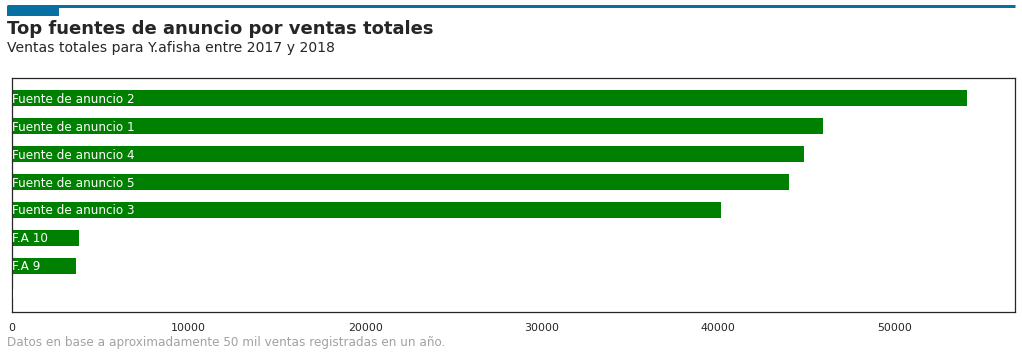

In [110]:
# Pasamos los valores del índice a una nueva columna
sales_by_source_grouped = sales_by_source_grouped.reset_index()

#Cambiamos los nombres de las fuentes

sales_by_source_grouped['source_id'] = sales_by_source_grouped['source_id'].replace(
    {1:'Fuente de anuncio 1', 2:'Fuente de anuncio 2', 3:'Fuente de anuncio 3', 4:'Fuente de anuncio 4',
    5:'Fuente de anuncio 5', 6:'Fuente de anuncio 6', 7:'Fuente de anuncio 7', 9:'F.A 9',10:'F.A 10'})

# Las ordenamos ascendentemente
top_source = sales_by_source_grouped.sort_values(by='revenue',ascending=True)
top_source_id = top_source['source_id']
top_source_id_revenue = top_source['revenue']

# La posición de las barras que nos permitirá determinar donde serán localizadas
z = [i * 0.9 for i in range(len(top_source_id))]

# Los colores que usaremos en el gráfico
blue = "#076fa2"
grey = "#a2a2a2"

# Nuestro gráfico de barras horizontal
fig, az = plt.subplots(figsize=(14, 5))
az.barh(z, top_source_id_revenue , height=0.55, align='edge', color='green')

# Escondemos las etiquetas del eje y
az.yaxis.set_visible(False)

# Agregamos las etiquetas
PAD = 0.3
for source_id, revenue, z_pos in zip(top_source_id, top_source_id_revenue, z):
    az.text(
        PAD, z_pos + 0.5 / 2, source_id, 
        color='white', fontfamily='DejaVu Sans', fontsize=12, va="center",
        path_effects=None
    ) 

# Ajustamos la posición del gráfico
fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.15)

# Añadimos el título
fig.text(
    0, 0.925, "Top fuentes de anuncio por ventas totales", 
    fontsize=18, fontweight="bold", fontfamily='DejaVu Sans'
)
# Añadimos subtítulo
fig.text(
    0, 0.875, "Ventas totales para Y.afisha entre 2017 y 2018", 
    fontsize=14, fontfamily='DejaVu Sans'
)

# Leyenda bajo el gráfico
source = "Datos en base a aproximadamente 50 mil ventas registradas en un año."
fig.text(
    0, 0.06, source, color=grey, 
    fontsize=12, fontfamily='DejaVu Sans'
)

# Añadimos una línea y rectángulo para la presentación del gráfico
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color=blue, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color=blue))

- **La fuente de anuncios que mayores ventas registra es la fuente nro. 2** con ventas totales que superan los 50 mil entre 2017 y 2018.


- Tanto la fuente nro 1, 4 y 5 le siguen respectivamente, con una diferencia estrecha entre ellas y con una cifra cercana a 45 mil en total.


- La fuente nro. 3 se aleja un poco con una cifra cercana a 40 mil y ya después queda la fuente 10 y 9 con bajas ventas totales. La fuente nro 7 es prácticamente inexistente en el total.


Veamos ahora la cantidad de usuarios que realizaron compras por fuente de anuncio:

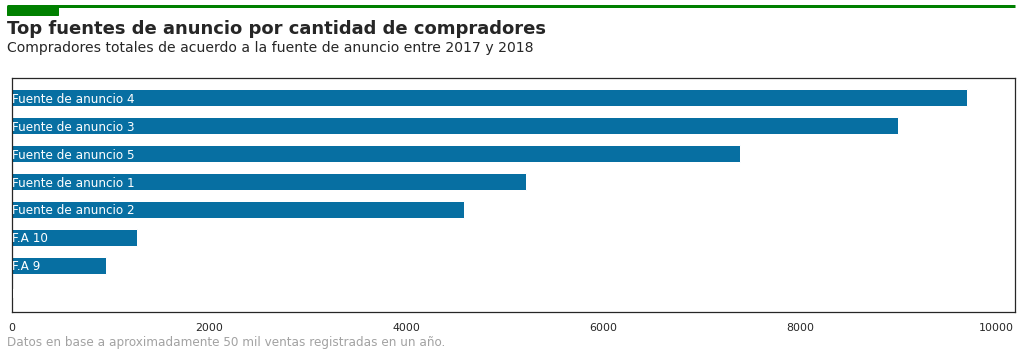

In [111]:
# Las ordenamos ascendentemente
top_source = sales_by_source_grouped.sort_values(by='uid',ascending=True)
top_source_id = top_source['source_id']
top_source_id_uid = top_source['uid']

# La posición de las barras que nos permitirá determinar donde serán localizadas
z = [i * 0.9 for i in range(len(top_source_id))]

# Los colores que usaremos en el gráfico
blue = "#076fa2"
grey = "#a2a2a2"

# Nuestro gráfico de barras horizontal
fig, az = plt.subplots(figsize=(14, 5))
az.barh(z, top_source_id_uid , height=0.55, align='edge', color=blue)

# Escondemos las etiquetas del eje y
az.yaxis.set_visible(False)

# Agregamos las etiquetas
PAD = 0.3
for source_id, uid, z_pos in zip(top_source_id, top_source_id_uid, z):
    az.text(
        PAD, z_pos + 0.5 / 2, source_id, 
        color='white', fontfamily='DejaVu Sans', fontsize=12, va="center",
        path_effects=None
    ) 

# Ajustamos la posición del gráfico
fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.15)

# Añadimos el título
fig.text(
    0, 0.925, "Top fuentes de anuncio por cantidad de compradores", 
    fontsize=18, fontweight="bold", fontfamily='DejaVu Sans'
)
# Añadimos subtítulo
fig.text(
    0, 0.875, "Compradores totales de acuerdo a la fuente de anuncio entre 2017 y 2018", 
    fontsize=14, fontfamily='DejaVu Sans'
)

# Leyenda bajo el gráfico
source = "Datos en base a aproximadamente 50 mil ventas registradas en un año."
fig.text(
    0, 0.06, source, color=grey, 
    fontsize=12, fontfamily='DejaVu Sans'
)

# Añadimos una línea y rectángulo para la presentación del gráfico
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color='green', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='green'))

- Se mantiene la relación que vimos en la sección pasada con la cantidad de visitas por fuente de anuncios; **la fuente nro.4, 3 y 5 se muestran como las más populares y también se refleja en la cantidad de usuarios que compran en el sitio.** 


- No obstante lo anterior, nos hemos dado cuenta que **la fuente nro.2 es la que mayores ganancias reporta pero está en quinto lugar de cantidad de clientes**, superando levemente los 4000 usuarios.


Será necesario visualizar las ventas totales distribuídas por mes, como también el ingreso per cápita dependiendo de la fuente.

Text(0.5, 0, 'Mes y año')

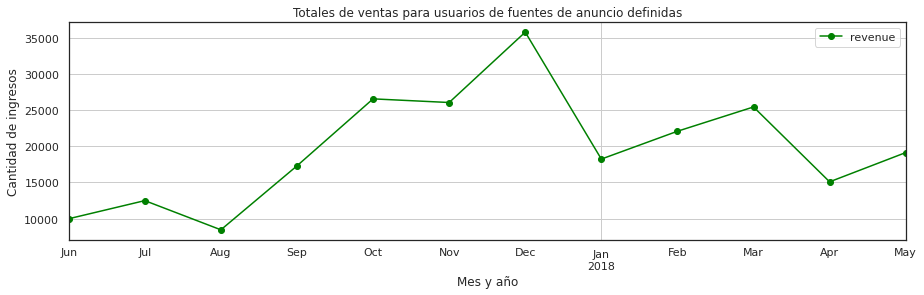

In [112]:
# Ventas totales por mes
sales_by_month = sales_by_source.groupby('order_month').agg({'uid':'nunique', 'revenue':'sum'})

# Graficamos los totales de ventas por mes para usuarios que vienen de una fuente de anuncios definida
sales_by_month.plot(y='revenue',style='-o', title= 'Totales de ventas para usuarios de fuentes de anuncio definidas', 
                                grid= True, color='green', figsize=(15,4))

plt.ylabel('Cantidad de ingresos')
plt.xlabel('Mes y año')

**El gráfico corresponde a las ventas de aquellos clientes que provinieron de alguna fuente de anuncios. Recordamos que existen usuarios que registran compras pero no existe una claridad de su fuente.**

- El mes de diciembre de 2017 figura como el mejor mes llegando a superar los 35 mil en ingresos. 
 
 
- Los primeros tres meses las ventas están por debajo de los 15 mil, quedando como los meses con menores ventas. A partir de septiembre de 2017 comienzan a aumentar llegando a su punto máximo en diciembre.


- Durante el año 2018, las ventas decaen fuertemente en enero pero vuelven a superar los 20 mil hacia febrero y marzo.


Veamos el comportamiento mensual ahora por usuario (ingreso per cápita) y por mes.

<AxesSubplot:title={'center':'Ingresos per cápita mensual de acuerdo a la fuente de anuncio de la que provienen los usuarios'}, xlabel='order_month', ylabel='source_id'>

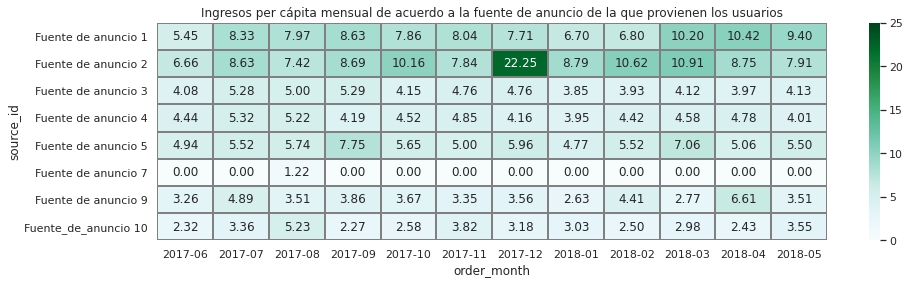

In [113]:
# Volvemos a agrupar, esta vez por fuente de anuncios y mes de orden
sales_by_source_month = sales_by_source.groupby(['source_id', 'order_month']).agg({'uid':'nunique', 'revenue':'sum'})

# Agregamos columna de ingresos por usuario
sales_by_source_month['revenue_per_user'] = sales_by_source_month['revenue'] / sales_by_source_month['uid']

# Reiniciamos índice y pasamos source_id como columna
sales_by_source_month = sales_by_source_month.reset_index()

# Formateamos a string en formato date dejando solo el mes y año
sales_by_source_month['order_month'] = sales_by_source_month['order_month'].dt.strftime('%Y-%m') 

# Cambiamos de nombre las fuentes
sales_by_source_month['source_id'] = sales_by_source_month['source_id'].replace(
    {1:'Fuente de anuncio 1', 2:'Fuente de anuncio 2', 3:'Fuente de anuncio 3', 4:'Fuente de anuncio 4',
    5:'Fuente de anuncio 5', 6:'Fuente de anuncio 6', 7:'Fuente de anuncio 7', 9:'Fuente de anuncio 9',
    10:'Fuente_de_anuncio 10'})

# Creamos una tabla dinámica
sales_source_month_pivot = sales_by_source_month.pivot_table(
    index='source_id', columns='order_month', values='revenue_per_user', aggfunc='mean')

# Redondeamos los valores
sales_source_month_pivot = sales_source_month_pivot.round(2)
# Rellenamos los valores ausentes para la fuente de anuncios 7
sales_source_month_pivot = sales_source_month_pivot.fillna(0)

# Visualizamos la tabla en un mapa de calor
sns.set(style='white')
plt.figure(figsize=(15,4))
plt.title('Ingresos per cápita mensual de acuerdo a la fuente de anuncio de la que provienen los usuarios')
sns.heatmap(sales_source_month_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap='BuGn', vmin=0, vmax=25)



**El mapa de calor muestra en tonos más oscuros los valores más altos per capita que gasta un cliente en la página. Los clientes están ordenados dependiendo de la fuente de anuncio de la que provengan.**

- Se reafirma la condición de la fuente nro.2 como la más exitosa en ventas alcanzando su máximo per cápita en diciembre con 22.25. 


- Tanto la fuente nro. 1 como la nro. 2 se distinguen con un promedio per cápita más alto que las demás durante todos los meses. Puede que esto se deba a un tipo de cliente particular al que apuntan estas fuentes.


- Una gran cantidad de visitas provienen de la fuente 3, 4 y 5; pero justamente aquellas no generan tantos ingresos per cápita como la 1 y 2.


- A nivel general, los ingresos per cápita en todas las fuentes de anuncio no varían mucho mes a mes, salvo en diciembre donde se incrementa demasiado para la fuente de anuncios 2. Posiblemente por alguna publicidad de fin de año para navidad o año nuevo.

**Ya hemos examinado el comportamiento de compra de los usuarios por cohorte, el tiempo que tardan en volverse clientes y las fuentes de anuncio más rentables;** pero, *¿Existirá alguna diferencia de ingresos por el dispositivo que se utiliza?*

#### Ventas de acuerdo al dispositivo usado

In [114]:
# Sacamos las columnas que queremos de los dataset a utilizar
visits_device = visits[['uid','device','first_session_month', 'session_date']]
orders_device = orders[['uid', 'revenue', 'order_month', 'order_date']]

# Cambiamos nombre de session_date a order_date para unir los registros y hacerlos coincidir en el día
visits_device.columns = ['uid','device','first_session_month', 'order_date']


# Unimos los datos que necesitamos
sales_by_device = visits_device.merge(orders_device, on=['uid','order_date'])

# Eliminamos duplicados
sales_by_device = sales_by_device.drop_duplicates().reset_index(drop=True)
sales_by_device

,uid,device,first_session_month,order_date,revenue,order_month
0,18188358787673499603,touch,2018-02-01,2018-02-12,0.73,2018-02-01
1,15857957287537270437,desktop,2017-09-01,2018-03-12,1.83,2018-03-01
2,15868686231870595097,touch,2018-03-01,2018-03-27,1.95,2018-03-01
3,18169507838259737849,desktop,2017-06-01,2017-10-03,2.75,2017-10-01
4,9344114199116964256,desktop,2018-02-01,2018-02-25,0.98,2018-02-01
...,...,...,...,...,...,...
41085,6752020629696526518,desktop,2017-12-01,2017-12-04,4.15,2017-12-01
41086,11750532881998794555,desktop,2017-11-01,2017-11-20,3.67,2017-11-01
41087,11202626539189016002,touch,2017-11-01,2017-11-29,3.05,2017-11-01
41088,12734910664455613822,desktop,2018-04-01,2018-04-23,0.49,2018-04-01


**Aplicamos el mismo procedimiento de antes con las fuentes de anuncio.** Ahora nos quedaron 41090 registros de un total de 50415 ordenes. La unión no encontró correspondencias de uid y fecha para algunos registros, por lo tanto no podemos determinar con exactitud el dispositivo para estos.

Trabajemos con los datos que tenemos:

Text(0.5, 0, 'Mes y año')

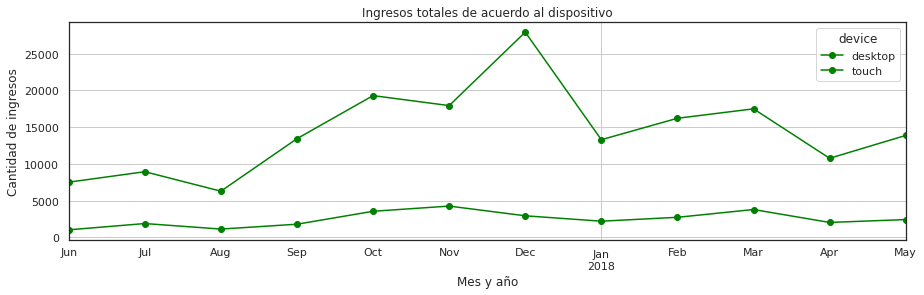

In [115]:
# Agrupamos por dispositivo y por mes
orders_by_device = sales_by_device.groupby(['device','order_month']).agg({'uid':'nunique', 'revenue':'sum'})

# Reseteamos el índice
orders_by_device = orders_by_device.reset_index()

# Creamos una tabla para graficar
orders_by_device = orders_by_device.pivot_table(index='order_month', columns='device',values='revenue')

# Graficamos los ingresos mensuales de acuerdo al dispositivo
orders_by_device.plot(style='-o', title= 'Ingresos totales de acuerdo al dispositivo', 
                                grid= True, color='green', figsize=(15,4))

plt.ylabel('Cantidad de ingresos')
plt.xlabel('Mes y año')


Anteriormente observamos que en cuanto a visitas, las curvas entre dispositivos eran similares guardando las proporciones de cantidad de usuarios. En ella vimos también que desde octubre a diciembre se producía un aumento en la cantidad de sesiones en computador de escritorio. En este caso, podemos describir lo siguiente en cuanto a las ventas:

- **Los ingresos en dispositivos de escritorio son ampliamente superiores**; si bien la curva de comportamiento es proporcional, se produce un peak importante en diciembre donde se alcanzan ingresos de casi 30 mil. Mientras tanto, para los dispositivos touch, solo alcanza los 3 mil ese mes.


- **Las alzas en uso de computador se producen justo en momentos donde aumentan las visitas y las ventas**; precisamente no se ven esas curvas de crecimiento en dispositivos touch, por lo tanto la preferencia por realizar compras en dispositivo de escritorio es clara.

Ya analizamos las ventas dependiendo de la fuente de anuncios y del dispositivo, ahora veamos las fechas que son mejores para el negocio:

#### Cantidad de pedidos en periodos más rentables

Con anterioridad evaluamos en un gráfico los ingresos totales por los nuevos usuarios de cada mes. Ahora analizaremos los periodos más rentables pero de acuerdo a la totalidad obtenida mensualmente, sin importar si son usuarios nuevos o viejos.

Volvamos a trabajar con el dataset orders.

In [116]:
# Agrupamos por mes y sumamos los totales
order_by_month = orders.groupby('order_month').agg({'uid':'count', 'revenue':'sum'})

# Reseteamos índice y pasamos columna order_month como columna
order_by_month = order_by_month.reset_index()

#Cambiamos nombre de columna 'uid' por ' total_orders'
order_by_month = order_by_month.rename(columns={'uid': 'total_orders'})

# Calculamos el promedio por orden
order_by_month['revenue_per_order'] = order_by_month['revenue'] / order_by_month['total_orders']

# Formateamos a string en formato date dejando solo el mes y año
order_by_month['order_month'] = order_by_month['order_month'].dt.strftime('%Y-%m') 

order_by_month

,order_month,total_orders,revenue,revenue_per_order
0,2017-06,2354,9557.49,4.060106
1,2017-07,2363,12539.47,5.306589
2,2017-08,1807,8758.78,4.847139
3,2017-09,3387,18345.51,5.416448
4,2017-10,5679,27987.70,4.928280
5,2017-11,5659,27069.93,4.783518
6,2017-12,6218,36388.60,5.852139
7,2018-01,4721,19417.13,4.112927
8,2018-02,5281,25560.54,4.840095
9,2018-03,5326,28834.59,5.413930


Observemos los periodos con más ingresos y la cantidad respectiva de pedidos que tuvieron.

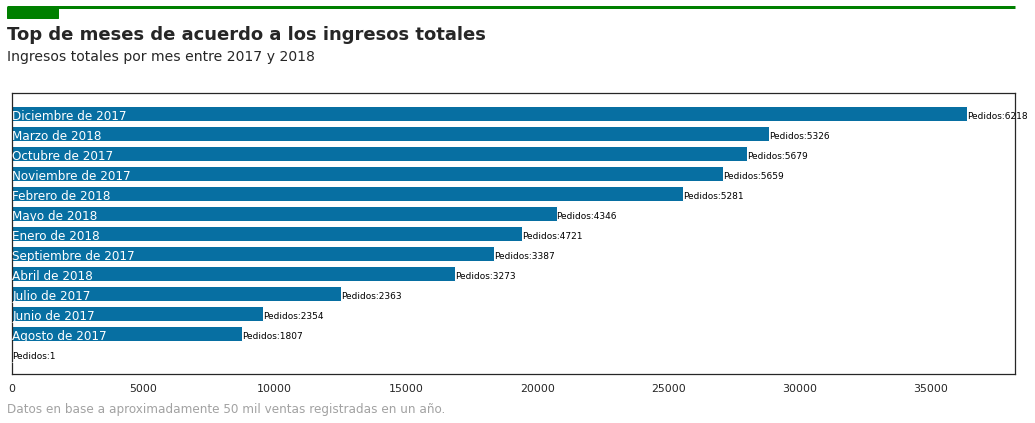

In [117]:
# Las ordenamos ascendentemente
top_month = order_by_month.sort_values(by='revenue',ascending=True)
top_month_id = top_month['order_month']
top_month_orders = top_month['total_orders']
top_month_revenue = top_month['revenue']

# Cambiamos de nombre los meses
top_month_id = top_month_id.replace({'2017-06':'Junio de 2017', '2017-07':'Julio de 2017', '2017-08':'Agosto de 2017', 
                                     '2017-09':'Septiembre de 2017', '2017-10':'Octubre de 2017', '2017-11':'Noviembre de 2017',
                                     '2017-12':'Diciembre de 2017', '2018-01':'Enero de 2018', '2018-02':'Febrero de 2018',
                                     '2018-03':'Marzo de 2018', '2018-04':'Abril de 2018', '2018-05':'Mayo de 2018', 
                                     '2018-06':'Junio de 2018'})

# La posición de las barras que nos permitirá determinar donde serán localizadas
z = [i * 0.9 for i in range(len(top_month_id))]

# Los colores que usaremos en el gráfico
blue = "#076fa2"
grey = "#a2a2a2"

# Nuestro gráfico de barras horizontal
fig, az = plt.subplots(figsize=(14, 6))
az.barh(z, top_month_revenue , height=0.7, align='edge', color=blue, )

# Escondemos las etiquetas del eje y
az.yaxis.set_visible(False)

# Agregamos las etiquetas
PAD = 0.3
for month_id, revenue, z_pos in zip(top_month_id, top_month_revenue, z):
    az.text(
        PAD, z_pos + 0.5 / 2, month_id, 
        color='white', fontfamily='DejaVu Sans', fontsize=12, va="center",
        path_effects=None
    ) 
    
# Agregamos etiquetas para la cantidad de ordenes totales
for month_orders, revenue, z_pos in zip(top_month_orders, top_month_revenue, z):       
        az.text(revenue + PAD, z_pos + 0.5 / 2 , 'Pedidos:'+ str(month_orders), 
                color='black', fontfamily='DejaVu Sans', fontsize=9, va="center", path_effects=None
    ) 

# Ajustamos la posición del gráfico
fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.15)

# Añadimos el título
fig.text(
    0, 0.925, "Top de meses de acuerdo a los ingresos totales", 
    fontsize=18, fontweight="bold", fontfamily='DejaVu Sans'
)
# Añadimos subtítulo
fig.text(
    0, 0.875, "Ingresos totales por mes entre 2017 y 2018", 
    fontsize=14, fontfamily='DejaVu Sans'
)

# Leyenda bajo el gráfico
source = "Datos en base a aproximadamente 50 mil ventas registradas en un año."
fig.text(
    0, 0.06, source, color=grey, 
    fontsize=12, fontfamily='DejaVu Sans'
)

# Añadimos una línea y rectángulo para la presentación del gráfico
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color='green', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='green'))

- El mes que **más ingresos tuvo fue diciembre de 2017, superando los 35 mil** y distanciandose bastante de sus seguidores que registran menos de 30 mil. Ese mismo mes la **cantidad de pedidos fue de 6218, la mayor cantidad registrada para un mes.** Consideramos que los altos valores para este mes tienen relación con las **festividades de fin de año.**


- Entre el **rango de ingresos de 25 mil a 30 mil** se encuentran los meses de: **Marzo del 2018, Octubre del 2017, Noviembre del 2017 y Febrero de 2018**. SI observamos con detención, el único mes que no se encuentra en el rango de Octubre 2017 a Febrero 2018 es Enero. En estos periodos la cantidad de pedidos oscila entre **5200 a 5700 pedidos.**


- Como mencionamos anteriormente, enero es el único mes del tramo de más ganancias que genera menos ingresos (no supera los 20 mil). Esto se puede deber al impacto que tuvo el gasto en general para los clientes el mes de diciembre. 


- **Los meses de más bajos ingresos** que también coinciden con los de menos pedidos, son los tres primeros de nuestro dataset: **junio, julio y agosto del 2017**. Esto se puede deber a que recién comenzaban las operaciones del negocio.**Los pedidos aquí oscilan entre la cantidad de 1800 y 2400.**


Veamos la gráfica de la cantidad de pedidos para establecer relaciones con los ingresos totales obtenidos:

Text(0.5, 0, 'Mes y año')

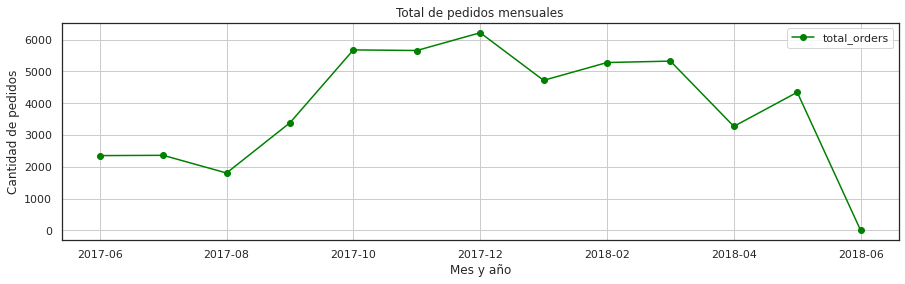

In [118]:
# Graficamos los pedidos totales por mes 
order_by_month.plot(y='total_orders', x='order_month',style='-o', title= 'Total de pedidos mensuales', 
                                grid= True, color='green', figsize=(15,4))

plt.ylabel('Cantidad de pedidos')
plt.xlabel('Mes y año')


- Como ya vimos, el mes más rentable y con mayores pedidos es diciembre del 2017; le siguen octubre y noviembre con solo una diferencia de 20 pedidos (5679 y 5659).


- En cuarto lugar de cantidad de pedidos queda marzo de 2018, con 5326. Increíblemente este mes se mantiene en segundo lugar de ingresos y con menos pedidos que octubre y noviembre.


- Otro punto a destacar, es que claramente los primeros meses se registran menos pedidos, hasta que en septiembre se produce un quiebre y comienza el ascenso en ventas y también en visitas a nivel general para el sitio.


Veamos el factor de ingreso promedio por orden para contemplar qué meses obtuvieron un mejor márgen por cada pedido:


In [119]:
# Ordenamos de acuerdo al ingreso promedio por orden
order_by_month.sort_values(by='revenue_per_order', ascending=False)

,order_month,total_orders,revenue,revenue_per_order
6,2017-12,6218,36388.60,5.852139
3,2017-09,3387,18345.51,5.416448
9,2018-03,5326,28834.59,5.413930
1,2017-07,2363,12539.47,5.306589
10,2018-04,3273,16858.06,5.150645
4,2017-10,5679,27987.70,4.928280
2,2017-08,1807,8758.78,4.847139
8,2018-02,5281,25560.54,4.840095
5,2017-11,5659,27069.93,4.783518
11,2018-05,4346,20735.98,4.771279


- Los meses en los que se recibe un mayor márgen por orden es precisamente **diciembre en primer lugar con 5.85 por orden**, seguido de **septiembre**, quien no figuraba dentro de los primeros puestos en total de ingresos ni cantidad de ordenes, pero que mantiene un **promedio de 5.41 de ingresos por orden**.


- Con un márgen similar a septiembre se encuentra marzo de 2018 y le sigue julio de 2017, el que tampoco mostró altos niveles de venta ni muchos pedidos.


-En general el promedio por orden no dista mucho de un mes a otro; se encuentran entre los márgenes de 4 y 6 de ingresos por orden.


**Viendo estos valores generales podemos concluir que los montos promedio por orden van entre 4 y 6 cada mes, pero si analizamos la distribución de los datos, *¿seguirá la misma constante?*.** Revisemos la distribución mediante estadísticas y luego diagramas de caja:

In [120]:
# Vemos las estadísticas para los ingresos
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

- La media del valor de las ordenes es de 5, pero si consideramos su desviación estándar y el alto valor máximo presente, la mediana podría representar mejor la realidad de las ordenes, de en **promedio un valor de 2.5 por cada una.**


- Existen ordenes de valor 0, esto puede ser producto de un error o aplicación de descuento u oferta especial.


Gran parte de las ordenes se encuentra entre los rangos de 1 y 5, por lo tanto, para efectos del gráfico de caja, limitaremos la visualización a un máximo valor de 10:

<AxesSubplot:title={'center':'revenue'}, xlabel='order_month'>

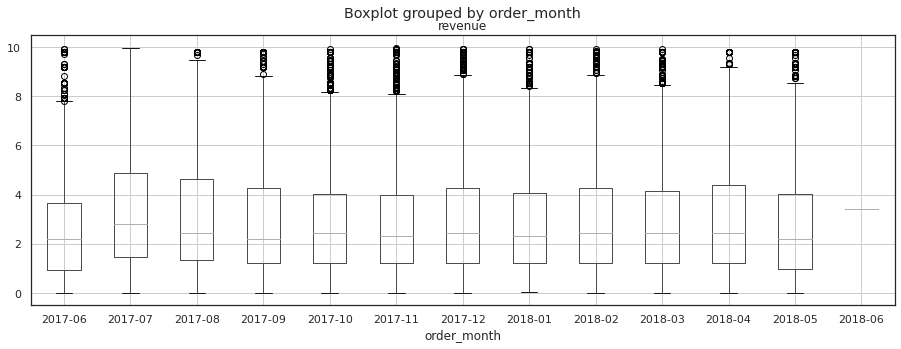

In [121]:
# Cambiamos de formato order_month
orders['order_month'] = orders['order_month'].dt.strftime('%Y-%m')

# Generamos el gráfico
orders.query('revenue <10').boxplot(column='revenue', by='order_month', grid=True, figsize=(15,5))

- Podemos ver que **la distribución para los meses es bastante similar**; al menos el 50% de las ordenes se mantiene entre los valores de 1 y 5.

- El mes que alzanza levemente valores más altos corresponde a julio de 2017, donde un 25% de ordenes se mantiene entre valores de 5 y 10.

Ya pudimos determinar los valores medios de las ordenes, el cómo se distribuyen mensualmente los valores de ingresos y cantidades totales de ordenes. Con todos los datos estudiados nos encontramos en buena posición de saber cuánto dinero traen los clientes.

#### Valor que los clientes aportan al sitio

Al comienzo del análisis de las ventas, generamos un mapa de calor que nos mostraba los ingresos por usuario de acuerdo a los cohortes de clientes que iban llegando mes a mes. Ahora, vamos a medir la cantidad total que los clientes aportan en promedio a la empresa.

Recordemos la tabla dinámica del aporte de los clientes de acuerdo al ciclo de vida:

In [122]:
# Tabla de ingresos por cohorte
orders_by_cohort.head()

,first_order_month,order_month,uid,revenue,revenue_per_user,cohort_lifetime
0,2017-06,2017-06-01,2023,9557.49,4.724414,0
1,2017-06,2017-07-01,61,981.82,16.095410,1
2,2017-06,2017-08-01,50,885.34,17.706800,2
3,2017-06,2017-09-01,54,1931.30,35.764815,3
4,2017-06,2017-10-01,88,2068.58,23.506591,4


Podemos ver el ingreso total por mes para cada cohorte y la cantidad total de usuarios en la columna 'uid'.


**Calcularémos el LTV (valor de vida del cliente) promedio para cada cohorte.** Para efectos de análisis, consideraremos el LTV como el ingreso acumulado por cohorte. No sabemos aún el beneficio bruto y no contamos con el márgen de rentabilidad para calcularlo de forma más específica.


Teniendo en cuenta todo esto, ya hemos calculado el LTV en la sección: **3.3.2 Pedidos distribuidos en cohortes de usuarios nuevos mensuales.** Recordamos el gráfico pero visto en forma de ranking y algunas conclusiones que hicimos en el momento:

In [123]:
# Pasamos los valores del índice a una nueva columna
cohort_orders_grouped = cohort_orders_grouped.reset_index()

# Formateamos a string en formato date dejando solo el mes y año
cohort_orders_grouped['first_order_month'] = cohort_orders_grouped['first_order_month'].dt.strftime('%Y-%m')

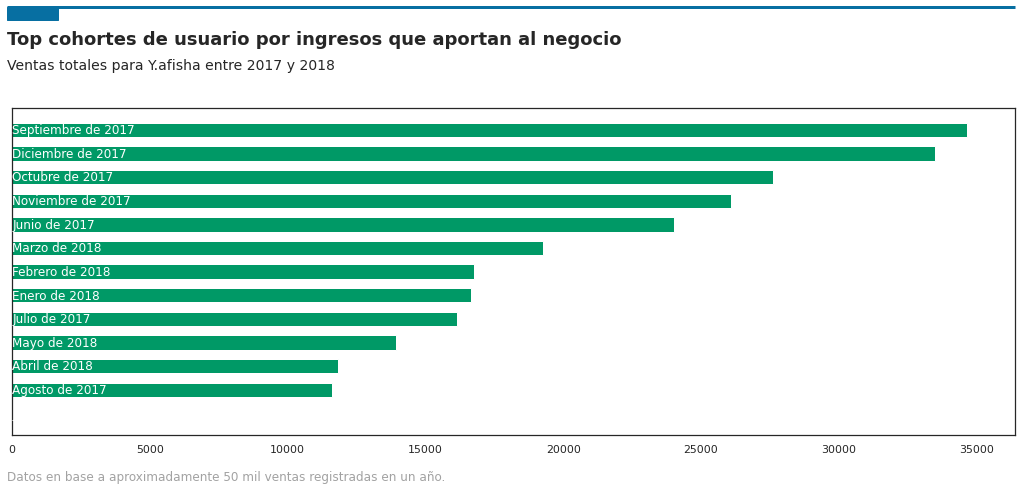

In [124]:

# Cambiamos de nombre los meses
cohort_orders_grouped['first_order_month'] = cohort_orders_grouped['first_order_month'].replace({
    '2017-06':'Junio de 2017', '2017-07':'Julio de 2017', '2017-08':'Agosto de 2017', 
    '2017-09':'Septiembre de 2017', '2017-10':'Octubre de 2017', '2017-11':'Noviembre de 2017',
    '2017-12':'Diciembre de 2017', '2018-01':'Enero de 2018', '2018-02':'Febrero de 2018',
    '2018-03':'Marzo de 2018', '2018-04':'Abril de 2018', '2018-05':'Mayo de 2018', '2018-06':'Junio de 2018'})

# Las ordenamos ascendentemente
top_cohort = cohort_orders_grouped.sort_values(by='revenue',ascending=True)
top_cohort_id = top_cohort['first_order_month']
top_cohort_revenue = top_cohort['revenue']

# La posición de las barras que nos permitirá determinar donde serán localizadas
z = [i * 0.9 for i in range(len(top_cohort_id))]

# Los colores que usaremos en el gráfico
blue = "#076fa2"
grey = "#a2a2a2"
green = "#009966"

# Nuestro gráfico de barras horizontal
fig, az = plt.subplots(figsize=(14, 7))
az.barh(z, top_cohort_revenue , height=0.55, align='edge', color= green)

# Escondemos las etiquetas del eje y
az.yaxis.set_visible(False)

# Agregamos las etiquetas
PAD = 0.3
for cohort_id, cohort_revenue, z_pos in zip(top_cohort_id, top_cohort_revenue, z):
    az.text(
        PAD, z_pos + 0.5 / 2, cohort_id, 
        color='white', fontfamily='DejaVu Sans', fontsize=12, va="center",
        path_effects=None
    ) 

# Ajustamos la posición del gráfico
fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.15)

# Añadimos el título
fig.text(
    0, 0.925, "Top cohortes de usuario por ingresos que aportan al negocio", 
    fontsize=18, fontweight="bold", fontfamily='DejaVu Sans'
)
# Añadimos subtítulo
fig.text(
    0, 0.875, "Ventas totales para Y.afisha entre 2017 y 2018", 
    fontsize=14, fontfamily='DejaVu Sans'
)

# Leyenda bajo el gráfico
source = "Datos en base a aproximadamente 50 mil ventas registradas en un año."
fig.text(
    0, 0.06, source, color=grey, 
    fontsize=12, fontfamily='DejaVu Sans'
)

# Añadimos una línea y rectángulo para la presentación del gráfico
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color=blue, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color=blue))


- **Los usuarios de septiembre de 2017 son los que contribuyen más al negocio, llegando a la cifra de 35 mil.** 


- En segundo lugar y bastante cerca le sigue diciembre del 2017. Recordemos que este mes se puede ver potenciado por nuevos clientes que llegan por época festiva.


- Octubre, Noviembre y Junio de 2017 le siguen respectivamente. Debemos recordar que también todos estos usuarios han tenido más tiempo para realizar compras en la plataforma.


- Los usuarios de agosto de 2017 son los que peores beneficios han entregado , llegando a estar por debajo de los ingresos generados por los usuarios de 2018.


Veamos ahora brevemente un ranking del promedio per cápita que aportan los usuarios de cada cohorte. Esta estadística nos puede servir de mejor manera para orientar nuestros esfuerzos de marketing hacia esos consumidores.

In [125]:
# Creamos columna de ingreso por usuario
cohort_orders_grouped['revenue_per_user'] = cohort_orders_grouped['revenue'] / cohort_orders_grouped['uid']

cohort_orders_grouped.sort_values(by='revenue_per_user', ascending=False)

,first_order_month,uid,revenue,revenue_per_user
3,Septiembre de 2017,2581,34676.32,13.435227
0,Junio de 2017,2023,24031.69,11.879234
2,Agosto de 2017,1370,11606.26,8.471723
1,Julio de 2017,1923,16127.92,8.386854
6,Diciembre de 2017,4383,33485.74,7.639913
5,Noviembre de 2017,4081,26098.99,6.395244
4,Octubre de 2017,4340,27603.45,6.360242
9,Marzo de 2018,3533,19273.41,5.455253
10,Abril de 2018,2276,11810.61,5.189196
7,Enero de 2018,3373,16663.13,4.940151


Ahora vemos ordenado por meses los usuarios que tienen un mejor comportamiento y nos entregan más beneficios per cápita.

**Los primeros 3 lugares son para los usuarios de:**

    - Septiembre de 2017
    - Junio de 2017
    - Agosto de 2017
    
    
- Podemos notar que diciembre de 2017 salió de los primeros lugares, debido a la gran alza de clientes ese mes.


- Los usuarios de agosto de 2017 si entregaban buenos beneficios per cápita, solamente es menor la cantidad de usuarios de este mes por lo tanto no se notan en el global.


- Para concluir, **los usuarios que han hecho su primera compra entre Junio y Septiembre de 2017, han aportado mayores beneficios de forma individual. Debemos considerar que llevan más tiempo en la plataforma por lo tanto pueden sumar más pedidos.**

#### Conclusiones respecto a las ventas

Realizamos distintos análisis a partir de los enfoques previstos en la sección de preguntas preliminares. En este apartado de conclusiones, daremos cuenta del paso a paso y la información relevante que obtuvimos a través de todas las metodologías aplicadas.

**Primero;** trabajamos a partir del dataset *orders* ya que en él se encuentra toda la información relativa a ventas. Para apreciar de mejor forma el comportamiento de los usuarios, creamos una columna de "primera orden" para separar a los clientes en grupos de acuerdo al mes de su primera compra.

**Al calcular la fecha del primer pedido, obtuvimos la siguiente información:**

- 36523 usuarios realizaron pedidos.

- La cantidad de ordenes del dataset llega a la cantidad de 50415.


**Segundo;** respecto a la **fecha de inicio de compra** en la pregunta: "*¿Cuándo comienzan a comprar las personas?*", agrupamos en cohortes de mes de compra y obtuvimos el siguiente resultado:


- Desde Septiembre de 2017 se presenta un alza en los clientes que hacen su primera compra.
    
    
- **Octubre y Diciembre de 2017 son los meses en que más usuarios nuevos realizan compras superando los 4000.**
    
    
 - Para el año 2018 se experimenta un descenso de nuevos clientes (1000 aprox. respecto al peak) pero se mantiene más alto que los primeros meses.
    
    
Para complementar la respuesta a esta pregunta, elaboramos otra: "*¿Cuánto tardan en comprar los usuarios desde que inician sesión por primera vez?*" las conclusiones fueron las siguientes:

- **Al menos la mitad de usuarios que realizaron compras en el sitio, solo demoraron 16 minutos desde que iniciaron sesión por primera vez.**
    
- 2455 usuarios registran un mismo tiempo de primera sesión que de compra. Esto puede dar cuenta de un error al registrar el tiempo de los clientes, ya que es imposible que tarden 0 segundos en hacer un pedido desde que inician sesión.
    
- El comportamiento por cohortes muestra que el tiempo es similar para todos y no tardan más de 30 min. en hacer una orden; sin embargo, **en usuarios de 2018 es algo más rápido (no más de 15 minutos)**. Esto puede deberse a muchas condiciones, por ejemplo: a un conocimiento previo de como funciona el sistema, las fuentes de anuncio son más claras en publicitar los procesos de compra, etc.
    

**Tercero,** respecto a las **ventas por canal de marketing** respondiendo a la pregunta *"¿Qué canal de marketing registra mayores ventas?"*

- Se encontraron errores en los que existian pedidos que no se podía rastrar su fuentes de anuncios ya que no se detectó un inicio de sesión que fuera correspondiente a una orden. Por esta razón, se procedió a crear otro dataset de orders para tener los datos de los que si podíamos extraer fuentes de anuncio.

- Por lo anterior, se eliminaron 8655 registros y se eliminaron duplicados producto del cruce de dataset para quedar con uno nuevo de 47886 ordenes.


Las conclusiones que obtuvimos de este conjunto de datos fueron las siguientes:

- La fuente que **mayores ventas registra es la nro.2**, con más de 50 mil de ingresos.
    
- **Le siguen las fuentes 1, 4 y 5** con ingresos cercanos a 45 mil en total.
    
- En cantidad de usuarios, **la fuente 4 es la que más atrae compradores** llegando casi a los 10 clientes. Le siguen las fuentes 3 y 5.
    
- A pesar de ser la que más ingresos genera, la fuente 2 está en los últimos lugares de cantidades de clientes, con solo 4000 aproximadamente.
    
- En relación al ingreso per cápita generado, las fuentes nro 1 y nro 2 llevan la delantera casi duplicando a las otras fuentes. 


Resumiendo lo anterior, **las fuentes que más ingresos generan son la 1 y 2 (seguramente por el tipo de público al que están enfocadas) mientras que la gran parte de clientes proviene de las fuentes 3, 4 y 5.**

**Cuarto;** respecto a las ventas en distintos **dispositivos**.

- Las ventas son proporcionales al comportamiento que se ve en las visitas, mantienen la misma curva, salvo el periodo de **fin de año donde se ve un crecimiento bastante alto en las compras por computador de escritorio**, llegando a sobrepasar en 10 veces aproximadamente el valor que se obtiene por dispositivos touch.

- A través de todos los meses, las ventas en computador de escritorio son ampliamente superiores.
    
    
**Quinto;** respecto los **periodos más rentables**, respondiendo a la pregunta: *"¿Cuántos pedidos se hacen en los periodos más rentables? ¿Cuántos se hacen en los menos?"*

- **El periodo de mayores ventas fue de diciembre de 2017**, con casi 50 mil de ingresos; y donde **también se alcanzó el nro. más alto de órdenes, llegando a las 6218.** Posiblemente relacionado a las festividades de fin de año.
    
    
- Otros meses con buena cantidad de **pedidos (5200 a 5700)** corresponden al periodo de **octubre de 2017 a febrero de 2018 (exceptuando enero)**. El éxito en este tramo puede corresponder a un factor de estacionalidad.
    
    
- Los periodos menos rentables son los iniciales, desde junio a agosto, llegando a tener como máximo 2400 pedidos. Esto puede ser producto de que el sitio estaba recién comenzando y en una estación no muy favorable para el negocio.


**Sexto;** respecto a la pregunta: "*¿Cuál es el monto promedio de las compras?*"

- Debido a la presencia de valores atípicos altos, el valor de la mediana podría representar de mejor forma la media de las ordenes, la cual es de **2.5 por orden. **
    
    
- **Al menos el 50% de las ordenes se presenta en el rango de 1 a 5 de ingresos.**


**Séptimo;** Respecto al **valor que aportan los clientes al sitio** y respondiendo a la pregunta "*¿Cuánto dinero traen los clientes?*" 

 Esta pregunta se resolvió al comienzo del análisis cuando revisamos gráficamente el comportamiento de los ingresos por cohorte. Además, revisamos el promedio de compra por usuario de acuerdo al ciclo de vida de cada cohorte. Las conclusiones fueron las siguientes:


- **Los usuarios del primer cohorte (junio de 2017) son los que presentan un mayor promedio mes a mes.** Y esto fue en incremento gradual que solo **a partir del tercer mes superó la barrera de los 20 de ingreso por usuario.** Desde ahí en adelante se sostuvo este buen comportamiento.
    
    
- **Otro cohorte de buen comportamiento es el de septiembre de 2017.** Los usuarios de este mes tendrían el **peak de ventas de todo el conjunto de cohortes a su tercer mes (diciembre 2017)** posiblemente afectados por las festividades.
    
    
- Para el cohorte de diciembre de 2017 también se ve un comportamiento positivo, a su tercer mes aumentan los ingresos hasta alcanzar entre 40 y 50 de ingresos por usuario en promedio.
    
    
Si analizamos directamente el **LTV** como lo que aporta **cada cohorte en total**, los resultados son los siguientes:

- **Los usuarios de septiembre de 2017 son los que más aportan al negocio, llegando a 35 mil de ingresos.**
    
    
- En segundo lugar, los que más aportan son los de diciembre de 2017, afectados posiblemente por el fin de año.
    
    
- **De forma individual, podemos notar que los usuarios que más aportan son los que han hecho su primera compra entre junio y septiembre de 2017.** Es importante considerar también que llevan mucho más tiempo en la plataforma.
    

### Análisis de datos: costos de marketing

**Evaluemos la salud del negocio encontrando el márgen de beneficio por venta:**

In [126]:
# Examinamos el dataset 'costs'
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [127]:
# Vemos la cantidad de datos del dataset
len(costs)

2542

Recordemos que el dataset 'costs' representa los datos de los gastos de marketing en el sitio; específicamente, los gastos por fuente de anuncio en un día puntual.


Si sumamos todos estos costos, tenemos los únicos gastos variables de los que disponemos. Calculémos el total de ingresos y el total de costos variables para obtener el márgen de beneficio del negocio por ventas.

In [128]:
# Total de costos variables
var_costs = costs['costs'].sum()

# Total de ingresos
total_revenue = orders['revenue'].sum()

# Beneficios obtenidos
benefits = total_revenue - var_costs

print('El dinero total que se ha gastado es de:', int(var_costs))
print('El ingreso total obtenido es:', int(total_revenue))
print('El beneficio que tenemos del negocio es:', int(benefits))

El dinero total que se ha gastado es de: 329131
El ingreso total obtenido es: 252057
El beneficio que tenemos del negocio es: -77074


**El resultado no es nada positivo, tenemos una pérdida de 77075.**

Examinemos la economía unitaria. Sin considerar gastos fijos (los cuales no disponemos), veamos cuánto es el ingreso y gasto por cada orden.

In [129]:
# Número total de ordenes
total_orders = len(orders)

# Ingreso por orden
one_order_revenue = total_revenue / total_orders
# Gasto variable por orden
one_order_var_costs = var_costs / total_orders
# Beneficio unitario
benefit_one_order = one_order_revenue - one_order_var_costs

print('El ingreso por orden es:', one_order_revenue)
print('El gasto por orden es:', one_order_var_costs)
print('El beneficio por orden es:', benefit_one_order)

El ingreso por orden es: 4.999646930477041
El gasto por orden es: 6.528446295745314
El beneficio por orden es: -1.5287993652682736


**El negocio no tiene beneficios, cada orden representa una pérdida de 1.5 aproximadamente.** Con estas condiciones claramente el negocio no puede escalarse.

Veamos al detalle el origen de estos gastos, es probable que algunas fuentes de anuncio no sean del todo rentables.

#### Gasto por fuente de anuncio

Recordemos que tenemos 9 fuentes de anuncios, y de ellas hay varias que no generan mayor beneficio para el negocio. Veamos cuál es el gasto para cada una:

Text(0.5, 0, 'Fuente de anuncios')

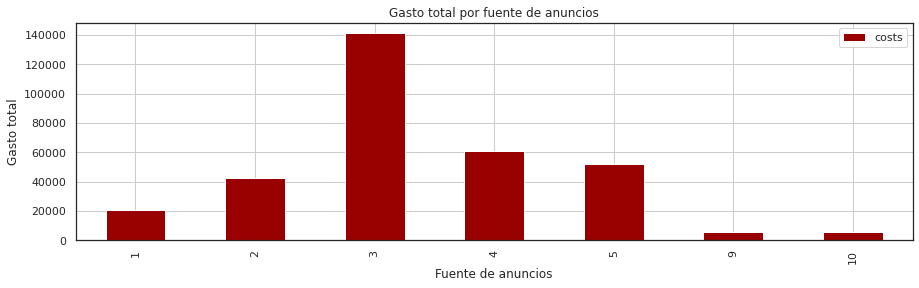

In [130]:
# Agrupamos por fuente de anuncio
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})

# Graficamos el costo de cada fuente de anuncios 
costs_by_source.plot(kind='bar', y='costs',style='-o', title= 'Gasto total por fuente de anuncios', grid= True, 
                     color='#990000', figsize=(15,4))

plt.ylabel('Gasto total')
plt.xlabel('Fuente de anuncios')


El gráfico es bastante notorio y se pueden apreciar grandes diferencias:

- **La fuente nro. 3 es la que representa un mayor gasto y supera los 140 mil.**

- La fuente más cercana viene a ser la nro. 4 pero con una amplia diferencia ya que solo llega a 60 mil aproximadamente. Le sigue la fuente 5 y luego la 2 con 50 mil y 40 mil en gastos respectivamente.

- En las que **menos gasto** se incurre son las **fuentes nro. 1 (con 20 mil aprox.) y la 9 y 10 que tienen cifras bajo los 10 mil.**

- La fuente 7 no genera gasto lo que se explica ya que hay muy pocos registros de visitas provenientes de esta fuente.


Veamos a continuación el detalle de los periodos en los que se incurrió tales gastos:

#### Periodos de los gastos de marketing

Comenzaremos por separar las fechas por el mes en el que fue hecho el gasto. Para esto crearemos una nueva columna en el dataset costs con el detalle del mes al que pertenece registro.

In [131]:
# Formateamos a string en formato date dejando solo el mes y año
costs['month'] = costs['dt'].dt.strftime('%Y-%m') 

Text(0.5, 0, 'Mes del gasto')

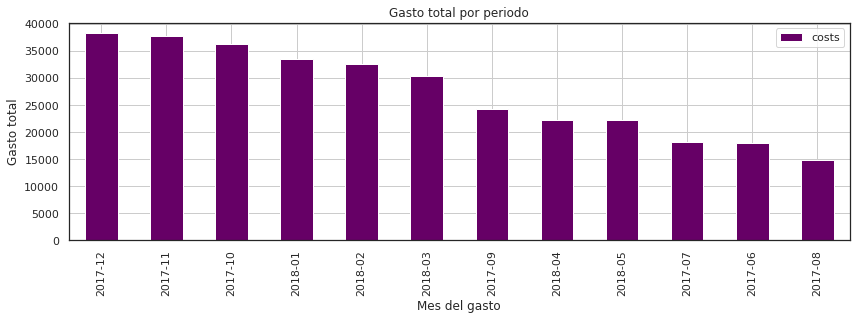

In [132]:
# Agrupamos por mes
costs_by_month = costs.groupby('month').agg({'costs':'sum'})


# Graficamos el costo por mes de forma descendiente
costs_by_month.sort_values(by='costs', ascending=False).plot(kind='bar', y='costs',style='-o', 
                                                             title= 'Gasto total por periodo', grid= True, 
                                                             color='#660066', figsize=(14,4))

plt.ylabel('Gasto total')
plt.xlabel('Mes del gasto')

- **Los meses que generan un mayor gasto de marketing son los que se acercan a fin de año**, les siguen los de comienzo de nuevo año.


- **Diciembre es el mes con gastos más elevados** llegando a cifras de 38 mil aprox. Noviembre le sigue de muy cerca con una diferencia menor a mil y luego octubre quien también sobrepasa también los 35 mil.


- El comienzo de nuevo año también trae cifras por sobre 30 mil pero bajo los 35 mil (a diferencia de fin de año).


- **Los meses de menores gastos corresponden posiblemente al inicio del negocio (desde junio del 2017) y los meses finales del dataset: abril y mayo de 2018.** Que este conjunto de meses sea más bajo también se puede explicar por la temporada; desde septiembre a marzo la actividad aumenta mucho en la plataforma y se podría considerar como el periodo fuerte.

Veamos las diferencias mensuales dependiendo de la fuente. Para esto visualizaremos el gasto por mes de cada fuente en un mapa de calor: 

<AxesSubplot:title={'center':'Gasto mensual de acuerdo a la fuente de anuncio'}, xlabel='month', ylabel='source_id'>

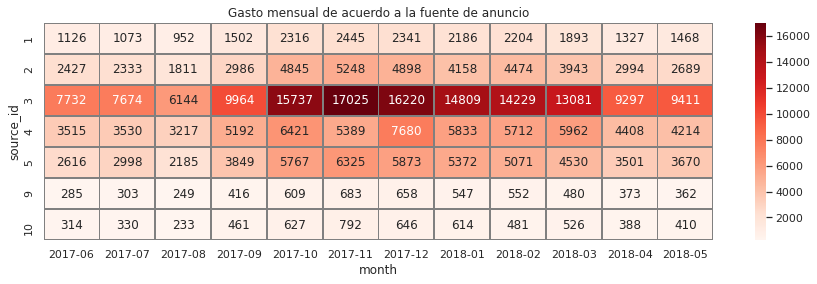

In [133]:
# Creamos una tabla dinámica
costs_source_grouped = costs.groupby(['source_id', 'month']).agg({'costs':'sum'})
costs_source_pivot = costs_source_grouped.pivot_table(
    index='source_id', columns='month', values='costs', aggfunc='mean')


# Visualizamos la tabla en un mapa de calor
sns.set(style='white')
plt.figure(figsize=(15,4))
plt.title('Gasto mensual de acuerdo a la fuente de anuncio')
sns.heatmap(costs_source_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray', cmap='Reds')

**En el mapa de calor se puede apreciar el gasto por fuente en cada mes. Los tonos más oscuros denotan un gasto más elevado.**

- Los gastos más elevados se concentran entre octubre de 2017 y marzo de 2018 para la fuente nro.3

- En general, los meses anteriormente mencionados representan un incremento para todas las fuentes, pero hay que notar la diferencia de que la fuente nro. 3 llega a triplicar en gasto a fuentes también populares como la 4 y 5.


#### Costo de adquisición de los clientes

Ya hemos calculado el LTV de manera general para cada cohorte bajo el concepto de "*los ingresos que nos pueden aportar al negocio*" dependiendo del mes en el que hayan hecho su primera compra. También hemos visto los gastos por fuente de anuncio para determinar cuáles son las más rentables. Ahora, usaremos la métrica del CAC (costo de adquisión de clientes) para calcular los esfuerzos en que tiene que incurrir la empresa para atraer cada tipo de cliente.

Nuestro costo de adquisición mensual ya lo tenemos en la siguiente tabla que creamos con anterioridad:

In [134]:
# Visualización de los primeros meses de costos
costs_by_month.head()

,costs
month,
2017-06,18015.00
2017-07,18240.59
2017-08,14790.54
2017-09,24368.91
2017-10,36322.88


Ahora, vamos a contraponerlos con los ingresos ordenados por cohortes de usuario(LTV):

In [135]:
# ingresos por cohortes de usuarios mensuales
ltv = orders.groupby('first_order_month').agg({'uid':'nunique','revenue':'sum'})
ltv.sort_values(by='revenue',ascending=False).head()

,uid,revenue
first_order_month,,
2017-09-01,2581,34676.32
2017-12-01,4383,33485.74
2017-10-01,4340,27603.45
2017-11-01,4081,26098.99
2017-06-01,2023,24031.69


De acuerdo al LTV por cohortes, los usuarios de septiembre y diciembre son los que más ingresos generan.

Unamos todos estos datos en una tabla para calcular el CAC.

In [136]:
# Reseteamos índice en ambas tablas
ltv = ltv.reset_index()
costs_by_month = costs_by_month.reset_index()

# Formateamos a string en formato date dejando solo el mes y año
ltv['first_order_month'] = ltv['first_order_month'].dt.strftime('%Y-%m')

#Cambiamos nombres de columnas en LTV
ltv.columns = ['month','n_buyers','revenue']

In [137]:
# Unimos con merge
report = ltv.merge(costs_by_month, on='month')

# Calculamos el CAC
report['cac'] = report['costs'] / report['n_buyers']

# Vemos como queda el costo de adquisición de acuerdo al cohorte ordenados por los más costosos
report.sort_values(by='cac', ascending=False)

,month,n_buyers,revenue,costs,cac
2,2017-08,1370,11606.26,14790.54,10.796015
7,2018-01,3373,16663.13,33518.52,9.937302
10,2018-04,2276,11810.61,22289.38,9.793225
1,2017-07,1923,16127.92,18240.59,9.485486
3,2017-09,2581,34676.32,24368.91,9.441654
5,2017-11,4081,26098.99,37907.88,9.288870
8,2018-02,3651,16750.50,32723.03,8.962758
0,2017-06,2023,24031.69,18015.00,8.905091
6,2017-12,4383,33485.74,38315.35,8.741809
9,2018-03,3533,19273.41,30415.27,8.608907


- Los clientes de agosto de 2017 resultan ser levemente más costosos que los demás. Le siguen enero de 2018 y abril de ese mismo año.


- Los costos por cliente de acuerdo a cohortes van desde los 7 a 11 aproximadamente por cliente.


- Los clientes de menor costo son los de mayo de 2018 y octubre de 2017.


No observamos ni un patrón claro y las diferencias son mínimas entre cohortes. Será mejor que apreciemos las diferencias de acuerdo a las fuentes de las que provienen y no por primer mes de compra.

Ya disponemos de una tabla con las ventas por fuente de anuncio, ordenemosla y añadamos los datos de costs:

Text(0.5, 0, 'Fuente de anuncios')

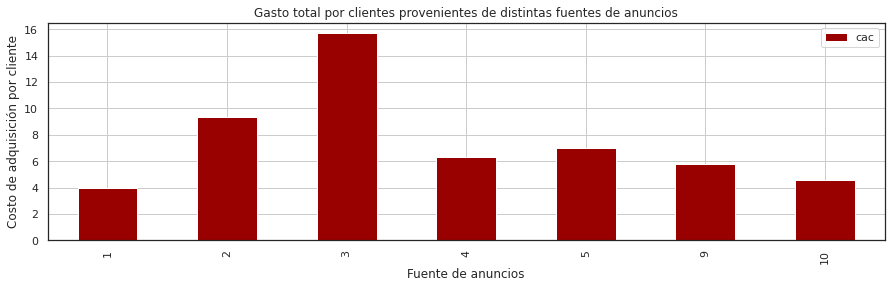

In [138]:
# LTV por fuente de anuncio
ltv_by_source = sales_by_source.groupby('source_id').agg({'uid':'nunique','revenue':'sum'})

# Reiniciamos el índice
ltv_by_source = ltv_by_source.reset_index()

# Ordenamos los costos por fuente de anuncio
cac_by_source = costs.groupby('source_id').agg({'costs':'sum'})

# Reiniciamos índice
cac_by_source = cac_by_source.reset_index()

# Unimos las tablas con merge en la columna source id
report_by_source = ltv_by_source.merge(cac_by_source, on='source_id')

# Creamos columna para calcular el costo por cliente
report_by_source['cac'] = report_by_source['costs'] / report_by_source['uid']


# Graficamos el costo de cada cliente por fuente de anuncios 
report_by_source.plot(kind='bar', y='cac', x='source_id',style='-o', title= 'Gasto total por clientes provenientes de distintas fuentes de anuncios', grid= True, 
                     color='#990000', figsize=(15,4))

plt.ylabel('Costo de adquisición por cliente')
plt.xlabel('Fuente de anuncios')

En esta comparación, mediante fuentes de anuncio, se pueden apreciar mayores diferencias que las hechas por cohortes de mes de primera compra.

- **La fuente nro. 3 tiene un costo de casi 16 por cliente, casi duplicando el costo del segundo lugar, la fuente nro 2**. que llega a un costo de 9 aproximadamente.


- Con un costo cercano a 7 está la fuente nro. 5 y cercano a ella le siguen las fuentes 4 y 9 con costos de 6 por cliente.


- La que presenta un **costo por cliente más bajo es la fuente nro. 1 que tiene un valor de 4 por cliente aprox.**

#### Retorno de la inversión

Para calcular el retorno de inversión, necesitamos obtener primero los LTV mensuales de acuerdo a fuente de anuncio. Veamos cuanto ingresa mensualmente de acuerdo a cohortes de usuarios por fuentes de anuncio:

In [139]:
# Agrupamos los datos que necesitamos
sbs_grouped = sales_by_source.groupby(['source_id','order_month']).agg({'uid':'nunique','revenue':'sum'})

# Reseteamos índice
sbs_grouped = sbs_grouped.reset_index()

In [140]:
# Formateamos a string en formato date dejando solo el mes y año
sbs_grouped['order_month'] = sbs_grouped['order_month'].dt.strftime('%Y-%m')

Ahora, agregamos el costo mensual agrupado por fuente de anuncio y mes. Luego lo unimos a la tabla anterior.

In [141]:
# Tabla con los costos por mes dependiendo de la fuente de anuncios
costs_grouped = costs.groupby(['source_id','month']).agg({'costs':'sum'})

# Reiniciamos el índice
costs_grouped = costs_grouped.reset_index()

# Cambiamos nombre de columna para unir
sbs_grouped.columns = ['source_id','month','n_buyers','revenue']

**Ya tenemos los datos que necesitamos agrupados para calcular el beneficio bruto por mes de acuerdo a usuarios por fuentes de anuncio:**

In [142]:
# Unimos los datos
ltv_by_source = sbs_grouped.merge(costs_grouped, on=['source_id','month'])

# Calculamos el beneficio bruto
ltv_by_source['gp'] = ltv_by_source['revenue'] - ltv_by_source['costs']

# Calculamos el LTV
ltv_by_source['ltv'] = ltv_by_source['gp'] / ltv_by_source['n_buyers']

# calculamos el cac
ltv_by_source['cac'] = ltv_by_source['costs'] / ltv_by_source['n_buyers']

ltv_by_source

,source_id,month,n_buyers,revenue,costs,gp,ltv,cac
0,1,2017-06,277,1509.62,1125.61,384.01,1.386318,4.063574
1,1,2017-07,290,2414.65,1072.88,1341.77,4.626793,3.699586
2,1,2017-08,197,1569.92,951.81,618.11,3.137614,4.831523
3,1,2017-09,381,3288.69,1502.01,1786.68,4.689449,3.942283
4,1,2017-10,597,4690.71,2315.75,2374.96,3.978157,3.878978
...,...,...,...,...,...,...,...,...
79,10,2018-01,86,260.56,614.35,-353.79,-4.113837,7.143605
80,10,2018-02,134,335.25,480.88,-145.63,-1.086791,3.588657
81,10,2018-03,174,517.68,526.41,-8.73,-0.050172,3.025345
82,10,2018-04,110,267.08,388.25,-121.17,-1.101545,3.529545


**Obtuvimos el beneficio bruto y el costo de adquirir cada cliente de acuerdo al mes y cohortes de fuentes de anuncio.** Calculemos ahora el retorno sobre la inversión (ROMI).

<AxesSubplot:title={'center':'Retorno sobre la inversión mensual para cohortes de usuario de acuerdo a fuentes de anuncio'}, xlabel='month', ylabel='source_id'>

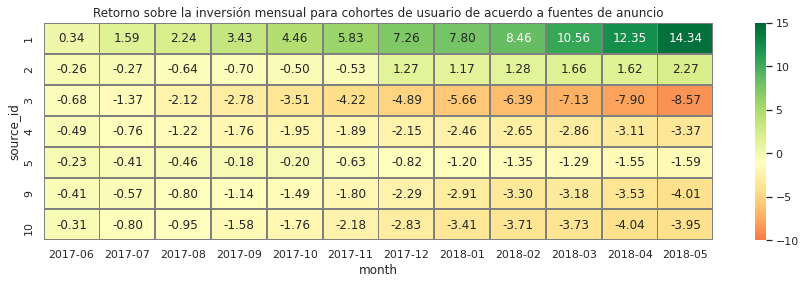

In [143]:
# Agregamos columna para romi
ltv_by_source['romi'] = ltv_by_source['ltv'] / ltv_by_source['cac']

# Creamos una tabla dinámica
final_report = ltv_by_source.pivot_table(index='source_id', columns='month', values='romi', aggfunc='mean')

final_report = final_report.cumsum(axis=1).round(2)

# Visualizamos la tabla en un mapa de calor
sns.set(style='white')
plt.figure(figsize=(15,4))
plt.title('Retorno sobre la inversión mensual para cohortes de usuario de acuerdo a fuentes de anuncio')
sns.heatmap(final_report, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap='RdYlGn',center=-1, vmin=-10, vmax=15)

**En el mapa de calor, los tonos más cercanos al verde indican una mejor rentabilidad. Los que se inclinan al amarillo y naranjo, representan la peor.**


- Para las únicas fuentes en que la inversión mejora con el tiempo es la número 1 y 2.


- **La fuente nro. 1 es la que presenta mejor rentabilidad, ya a partir del segundo mes (julio de 2017) trae beneficios y se mantiene en constante aumento.**


- **La fuente nro. 2 viene a dar una rentabilidad positiva solo a partir de diciembre de 2017**, el mes en que más actividad se genera. A partir de ahí, tiene una leve baja en enero pero retoma el ascenso de forma constante.


- Las otras fuentes de anuncio no son muy rentables, en especial la fuente nro. 3 que tiene los indices negativos más altos.

#### Conclusiones respecto a los gastos de marketing

Trabajamos a partir del dataset *costs* en el cual se encuentra la información de todos los gastos por fuente de anuncio y sus fechas asociadas.

**Primero;** respecto al **gasto total efectuado**. "*¿Cuánto dinero total se ha gastado?*"

- **Se ha gastado aproximadamente 329 mil en total para gastos de marketing.** Esto corresponde a la suma de los 2542 gastos registrados.


Este gasto es demasiado elevado comparado a los ingresos del negocio; es decir, el beneficio es negativa y tenemos una **pérdida de 77 mil aproximadamente.**

Si esto lo llevamos a su forma unitaria, se traduce a un **gasto por orden de 6.52** lo que nos otorga **pérdidas de 1.52 por orden.** No es un negocio escalable con esas condiciones. Tendríamos que aplicar ciertas estrategias para revertir esas pérdidas.

**Segundo;** respecto a **las fuentes de anuncio**. "*¿Cuánto dinero se ha gastado por cada fuente de anuncios?*"

- **La fuente nro. 3 representa un gasto bastante alto comparado a las demás**, llegando a la cifra de 140 mil. Todas las otras fuentes están por debajo de los 60 mil.

- Las fuentes 4, 5 y 2 tienen un gasto de 60 mil, 50 mil y 40 mil respectivamente.

- **Las fuentes de menos gastos son la nro. 1 con 20 mil; y la 9 y 10, cada una con menos de 10 mil.**


**Tercero;** respecto a **las fechas de los registros**. "*¿Cuáles han sido los periodos de mayor gasto de marketing?*"

- **Los periodos de mayor gasto son los meses que se acercan a fin de año**, teniendo su punto máximo de gasto en diciembre de 2017.

- Los puntos altos de gasto van desde octubre de 2017 hasta marzo de 2018, donde todos los meses se superan los 30 mil de gasto en marketing.


- **El factor "temporada" puede ser la razón de aumento de gasto en estas fechas**, ya que los meses de mitad de año tienen un gasto más bajo.


- Comparando los gastos por fuente de manera mensual, nos damos cuenta que **el gasto de la fuente 3 llega a triplicar el de otras fuentes populares como la 4 y la 5.**


**Cuarto;** respecto al **costo por cliente**. "*¿Cuánto costó la adquisición de clientes de cada una de las fuentes?*"

Investigamos los costos de adquisición por cohortes de primer mes de compra para ver si existía alguna diferencia significativa pero notamos que los costos van entre **7 y 11 por cliente** y no existe algún patrón claro en los meses. Agosto de 2017 es el mes más costoso de clientes, con un valor de casi 11 por cada uno; mientras que el más bajo es mayo de 2018, con un valore de poco más de 7 por cada uno.

Considerando lo anterior, examinamos el costo de clientes de acuerdo a las fuentes de anuncio. Estos fueron los resultados:

- **Adquirir clientes de la fuente nro. 3 cuesta 16 por cada uno aproximadamente.** Este resultado casi duplica al segundo costo más alto, el de la fuente nro.2, con un costo de 9 por cliente.


- La fuente nro. 1 figura como la de costo más bajo con un valor de 4 por usuario.


**Quinto;** respecto a la **rentabilidad**. "*¿Cuán rentable eran las inversiones?*"


Para obtener la rentabilidad primero calculamos el LTV (beneficio bruto), el CAC (costos de adquisición por cliente) y finalmente el ROMI(Retorno sobre la inversión). 


Agrupamos a los usuarios por fuentes de anuncio para determinar cuál fuente es más rentable. Durante el desarrollo de todo el análisis, pudimos observar que a través de los cohortes de primera fecha de compra no habían patrones claros en el comportamiento de los clientes. Separando a estos por fuentes de anuncio vimos que existen diferencias importantes en cantidad de ingresos que reportan cada una y el gasto que implica contar con cada una.

Mediante la observación del ROMI en un mapa de calor, confirmamos muchas de las conclusiones que veníamos armando con anterioridad:

- **La fuente nro 1. es con bastante superioridad la fuente más rentable.**


- Si bien la fuente nro. 2 representa una buena rentabilidad a su sexto mes, la relación del gasto genera con los beneficios que trae, está muy por detrás de la nro. 1.


- **Las otras fuentes si bien traen más visitas algunas, no se traduce en compradores.**

## Conclusiones finales

**Observaciones iniciales**

- El registro de ordenes presenta algunas que no tienen correspondencia con alguna sesión iniciada, es decir, existen compras de las que no hay una sesión activa, por lo que se hizo imposible relacionar todas las ordenes con la fuente de anuncio respectiva de la que provenía el usuario. Atribuímos a que se pueda tratar de un error de registro.

- En este mismo registro de pedidos, existen algunos con un monto igual a 0. No sabemos si se trata de un error u aplicación de alguna oferta especial.


**Actividad general en el sitio**
Los registros presentan un comportamiento más activo de parte de los usuarios hacia fines de año. Seguramente por la naturaleza del negocio de generar un mayor atractivo estacional, sobretodo para festividades de fin de año (queda demostrado por los buenos resultados de diciembre). Es el periodo donde mayores ingresos y cantidad de ordenes se reciben.


En general, los usuarios que han realizado compras en el sitio, tardan solo 16 minutos en emitir una orden de compra. Este tiempo es menor para usuarios que iniciaron compras en 2018. La plataforma llega de forma efectiva y el proceso es rápido desde que inician sesión. 
Respecto al uso de esta misma, existe una clara preferencia por el uso de computador de escritorio por sobre dispositivos táctiles a la hora de visitar o hacer compras en la página. El uso de computadores amplía más sus diferencias hacia fines de año.


**Sobre las ventas**

Existen meses en que el comportamiento de usuarios nuevos sobresale en compromiso y nivel de compras, esto es para los usuarios de junio de 2017, septiembre de 2017 (los usuarios que más ingresos aportaron) y diciembre de 2017. Estos tres meses representan fechas cruciales vistas durante todo el análisis. En junio comienzan las actividades del negocio; septiembre es el mes en que comienza un alza de visitas y ventas; diciembre es el mejor mes en visitas y ventas.

En cuanto al valor de los pedidos: al menos el 50% de las ordenes fluctúa entre el valor de 1 y 5.

Respecto a las fuentes: Las fuentes nro. 1 y 2 son las que mayores ingresos generan a la empresa, pero no son las que atraen mayor cantidad de clientes. Las que más volumen de personas mueven son las fuentes 3, 4 y 5.

**Sobre los gastos**

El gasto de marketing es demasiado elevado lo cual genera una pérdida de 77 mil solo considerando estos gastos variables versus los ingresos totales. 
Detectamos que la fuente de anuncios nro.3 representa un gasto demasiado grande en relación al beneficio que otorga, en solo esta fuente se gasta 140 mil, lo cual genera un costo de adquisición de 16 por cliente; mientras que la fuente que menos gasto genera (fuente nro.1) lo hace solo por 4 y es de las que más ingresos reporta a la empresa.


**Recomendaciones finales**

En base al retorno de inversión calculado para las fuentes de anuncio en las que gasta la empresa, se hace necesario dejar de invertir en la fuente nro. 3. Si bien gran parte de los usuarios provienen de esta fuente, esto no se traduce en compras y solo genera pérdidas cuantiosas al negocio. Solo con eliminar esta fuente ya se podría ver un saldo positivo.

La inversión debería estar dirigida hacia las fuentes nro 1. y nro 2. que son el objetivo de público que realiza compras finalmente.

Respecto a la presentación del sitio en computador de escritorio o dispositivos touch. Los usuarios prefieren realizar las compras en computador de escritorio posiblemente por temas de comodidad o compatibilidad. El mejorar el sistema para dispositivos táctiles no aseguraría un incremento de ventas ya que es bastante grande la diferencia de uso respecto a los usuarios de computador.
